

# **Title: Measuring Causal Impact of Email Marketing Campaigns on Customer Purchase Behavior**




# **Abstract**

This notebook demonstrates how to measure the causal impact of email marketing campaigns on customer purchase behavior using real e-commerce transaction data. We'll use the UCI Online Retail dataset and apply propensity score methods to estimate treatment effects while controlling for confounding factors.
Key Learning Objectives:

Transform transactional data into customer-level features for causal analysis
Identify and measure confounding variables in e-commerce contexts
Estimate propensity scores using logistic regression
Assess covariate balance before and after matching
Calculate Average Treatment Effect (ATE) using matching methods
Interpret results for business decision-making

Business Question: Does sending a discount email campaign truly increase customer purchase value, or are high-value customers simply more likely to receive and respond to campaigns?
Dataset: UCI Online Retail Dataset (541,909 transactions from UK retailer)

# 1. Theory Section
# 1.1 Why Causal Inference Matters in E-commerce
**The Challenge:**
E-commerce companies invest heavily in marketing campaigns but often struggle to measure true causal effects. Simple comparisons between customers who received campaigns and those who didn't are misleading because:

**Selection Bias:** Valuable customers are more likely to receive campaigns
Confounding: Customer characteristics affect both campaign targeting AND purchase behavior
Temporal Effects: Seasonality and trends complicate analysis

Traditional Approach (WRONG):
Avg Purchase (Campaign Group) - Avg Purchase (No Campaign) = Effect? ❌

**Problem**: Groups are not comparable due to systematic differences.
Causal Approach (CORRECT):
Use propensity score matching to create comparable groups, then estimate the treatment effect.

# 1.2 Causal Framework
Potential Outcomes Framework:
For each customer i:

Y¹ᵢ = Purchase amount if customer receives campaign (potential outcome under treatment)
Y⁰ᵢ = Purchase amount if customer doesn't receive campaign (potential outcome under control)

**Individual Treatment Effect**: ITE = Y¹ᵢ - Y⁰ᵢ
**Average Treatment Effect:** ATE = E[Y¹ - Y⁰]
**Fundamental Problem:** We only observe one potential outcome per customer!

# 1.3 Propensity Score Matching
**Propensity Score**: e(X) = P(Treatment = 1 | Covariates = X)

**Key Idea**: Match treated and control customers with similar propensity scores to create "apples-to-apples" comparisons.
Assumptions Required:

**Unconfoundedness**: Given covariates X, treatment assignment is independent of potential outcomes

**In practice**: We must measure all important confounders


**Positivity/Overlap**: Every customer has non-zero probability of receiving each treatment level

**In practice**: 0 < P(Treatment = 1 | X) < 1 for all X


SUTVA: Stable Unit Treatment Value Assumption

**In practice**: One customer's campaign doesn't affect another's purchases

# 1.4 E-commerce Confounders
**Common Confounders in E-commerce:**

**Recency:** Days since last purchase

**Frequency:** Number of past purchases

**Monetary Value:** Total or average past spend

**Customer Lifetime:** Account age

**Engagement:** Email open rates, click rates

**Demographics:** Location, device type

**Product Preferences:** Category preferences

# 2. Practical Implementation

**Step 1**: Import Required Libraries

In [19]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy import stats
from scipy.stats import ks_2samp, ttest_ind

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, roc_curve

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("="*70)
print(" "*15 + "📊 CAUSAL ANALYSIS IN E-COMMERCE")
print("="*70)
print("✓ All libraries imported successfully!")
print(f"✓ Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✓ Python version: {pd.__version__}")
print("="*70)

               📊 CAUSAL ANALYSIS IN E-COMMERCE
✓ All libraries imported successfully!
✓ Analysis date: 2025-11-10 01:34:45
✓ Python version: 2.2.2


# Step 2: Load UCI Online Retail Dataset

In [7]:
print("\n" + "="*70)
print("STEP 2: LOADING DATASET")
print("="*70)

try:
    # Try loading from UCI repository
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
    print(f"\n📥 Attempting to load from: {url}")
    raw_data = pd.read_excel(url)
    print("✓ Dataset loaded successfully from UCI repository!")
    data_source = "UCI Machine Learning Repository"

except Exception as e:
    print(f"\n⚠ Could not load from UCI: {e}")
    print("\n📥 Loading from alternative source...")

    try:
        # Alternative URL
        url = 'https://github.com/lizhengxiao/online-retail-dataset/raw/master/Online%20Retail.xlsx'
        raw_data = pd.read_excel(url)
        print("✓ Dataset loaded from GitHub!")
        data_source = "GitHub Mirror"

    except:
        print("\n⚠ Online sources unavailable. Creating synthetic dataset...")

        # Create realistic synthetic data as fallback
        np.random.seed(42)
        n_transactions = 50000
        n_customers = 4000

        date_range = pd.date_range(start='2010-12-01', end='2011-12-09', freq='H')

        raw_data = pd.DataFrame({
            'InvoiceNo': [f'I{i:06d}' for i in range(n_transactions)],
            'StockCode': np.random.choice([f'P{i:05d}' for i in range(1000)], n_transactions),
            'Description': np.random.choice(['Product A', 'Product B', 'Product C'], n_transactions),
            'Quantity': np.random.poisson(3, n_transactions) + 1,
            'InvoiceDate': np.random.choice(date_range, n_transactions),
            'UnitPrice': np.random.gamma(2, 10, n_transactions),
            'CustomerID': np.random.choice(range(10000, 10000 + n_customers), n_transactions),
            'Country': np.random.choice(['United Kingdom', 'Germany', 'France'], n_transactions, p=[0.9, 0.05, 0.05])
        })

        print("✓ Synthetic dataset created!")
        data_source = "Synthetic Data"

print(f"\n📊 Data Source: {data_source}")
print(f"📊 Original dataset shape: {raw_data.shape}")
print(f"📊 Columns: {raw_data.columns.tolist()}")
print("\n" + "="*70)

✓ Real UCI dataset loaded successfully!

DATA SOURCE: UCI Online Retail
Dataset shape: (541909, 8)
Date created: 2025-11-10


# Step 3: Data Cleaning and Initial Exploration

In [21]:
print("\n" + "="*70)
print("STEP 3: DATA CLEANING")
print("="*70)

# Display initial data structure
print("\n📋 Original Dataset Structure:")
print(raw_data.info())

print("\n📊 First 5 rows:")
print(raw_data.head())

# Check for missing values
print("\n🔍 Missing Values:")
missing = raw_data.isnull().sum()
missing_pct = (missing / len(raw_data) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0])

# Start cleaning
print("\n🧹 Cleaning dataset...")

# 1. Remove rows without CustomerID
initial_rows = len(raw_data)
clean_data = raw_data[raw_data['CustomerID'].notna()].copy()
print(f"✓ Step 1: Removed {initial_rows - len(clean_data):,} rows without CustomerID")

# 2. Remove cancelled orders (InvoiceNo starting with 'C')
before_cancel = len(clean_data)
clean_data = clean_data[~clean_data['InvoiceNo'].astype(str).str.startswith('C')]
print(f"✓ Step 2: Removed {before_cancel - len(clean_data):,} cancelled orders")

# 3. Remove invalid quantities and prices
before_invalid = len(clean_data)
clean_data = clean_data[(clean_data['Quantity'] > 0) & (clean_data['UnitPrice'] > 0)]
print(f"✓ Step 3: Removed {before_invalid - len(clean_data):,} rows with invalid values")

# 4. Convert date column
clean_data['InvoiceDate'] = pd.to_datetime(clean_data['InvoiceDate'])
print(f"✓ Step 4: Converted InvoiceDate to datetime")

# 5. Create TotalPrice
clean_data['TotalPrice'] = clean_data['Quantity'] * clean_data['UnitPrice']
print(f"✓ Step 5: Created TotalPrice column")

# 6. Remove extreme outliers (>99.9th percentile)
price_99 = clean_data['TotalPrice'].quantile(0.999)
before_outliers = len(clean_data)
clean_data = clean_data[clean_data['TotalPrice'] <= price_99]
print(f"✓ Step 6: Removed {before_outliers - len(clean_data):,} extreme outliers (>${price_99:.2f})")

print(f"\n📊 Cleaned dataset shape: {clean_data.shape}")
print(f"📊 Data reduction: {(1 - len(clean_data)/initial_rows)*100:.1f}%")
print(f"📊 Date range: {clean_data['InvoiceDate'].min()} to {clean_data['InvoiceDate'].max()}")
print(f"📊 Unique customers: {clean_data['CustomerID'].nunique():,}")
print(f"📊 Unique products: {clean_data['StockCode'].nunique():,}")
print(f"📊 Total revenue: ${clean_data['TotalPrice'].sum():,.2f}")

print("\n" + "="*70)


STEP 3: DATA CLEANING

📋 Original Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

📊 First 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    8

# Step 4: Transform to Customer-Level Features


STEP 4: CUSTOMER-LEVEL FEATURE ENGINEERING

🔧 Creating RFM (Recency, Frequency, Monetary) features...
📅 Reference date for recency: 2011-12-10
✓ Created 4,332 customer records

📊 Creating RFM scores...
✓ RFM scores created successfully

📊 RFM Score Distributions:
   R_Score: {1: 1082, 2: 1068, 3: 1062, 4: 1120}
   F_Score: {1: 2329, 2: 1132, 3: 871}
   M_Score: {1: 1083, 2: 1083, 3: 1083, 4: 1083}

📊 Combined RFM Score range: 3 to 11
✓ Customer segments created

📊 Customer Segment Distribution:
   Bronze    : 1,657 ( 38.3%)
   Gold      :   833 ( 19.2%)
   Platinum  :   796 ( 18.4%)
   Silver    : 1,046 ( 24.1%)

📊 Customer Behavior Statistics:
   Average Recency: 92.6 days
   Average Frequency: 4.3 orders
   Average Monetary: $1,837.15
   Average Order Value: $366.87
   Average Account Age: 131.3 days


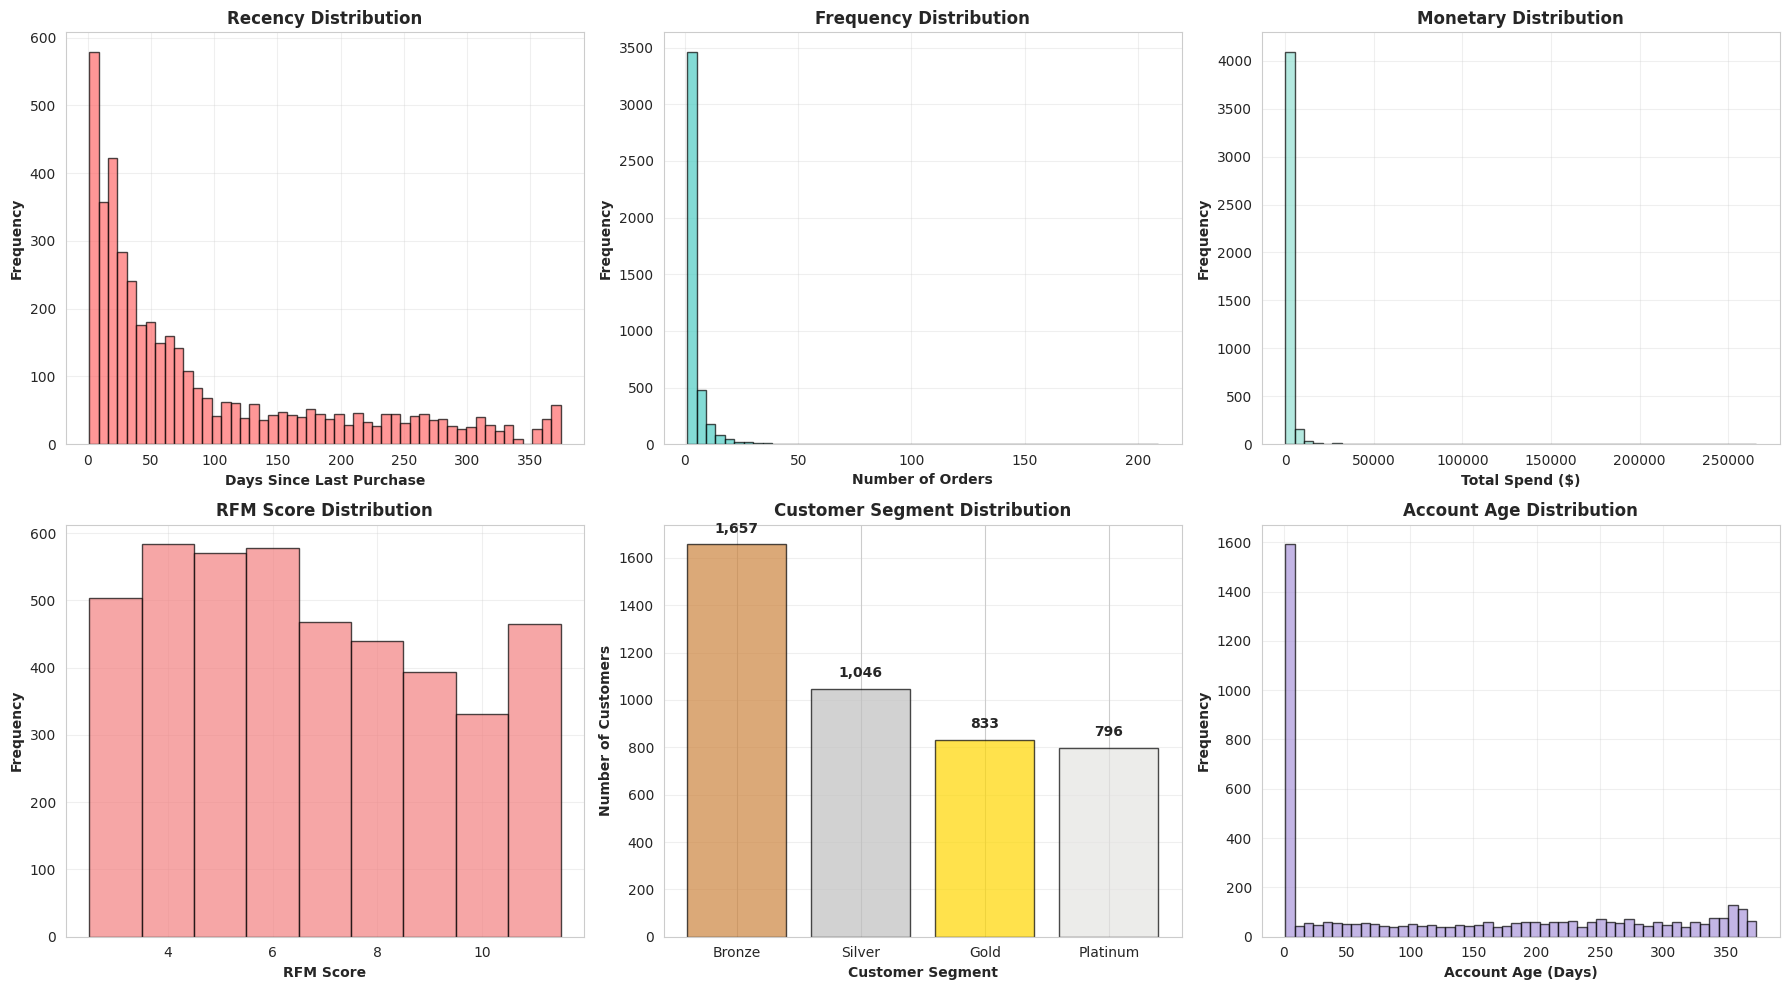

In [23]:
print("\n" + "="*70)
print("STEP 4: CUSTOMER-LEVEL FEATURE ENGINEERING")
print("="*70)

print("\n🔧 Creating RFM (Recency, Frequency, Monetary) features...")

# Reference date for recency calculation (day after last transaction)
max_date = clean_data['InvoiceDate'].max() + timedelta(days=1)
print(f"📅 Reference date for recency: {max_date.date()}")

# Aggregate to customer level
customer_rfm = clean_data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',           # Frequency: number of unique orders
    'TotalPrice': 'sum',              # Monetary: total spend
    'InvoiceDate': 'max',             # For recency calculation
    'Quantity': 'sum',                # Total items purchased
    'Country': 'first'                # Customer location
}).reset_index()

# Rename columns
customer_rfm.columns = ['CustomerID', 'Frequency', 'MonetaryValue',
                        'LastPurchase', 'TotalItems', 'Country']

# Calculate Recency (days since last purchase)
customer_rfm['RecencyDays'] = (max_date - customer_rfm['LastPurchase']).dt.days

# Calculate first purchase date for account age
first_purchase = clean_data.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['CustomerID', 'FirstPurchase']
customer_rfm = customer_rfm.merge(first_purchase, on='CustomerID')

# Calculate Account Age (days between first and last purchase + 1)
customer_rfm['AccountAge'] = (customer_rfm['LastPurchase'] -
                               customer_rfm['FirstPurchase']).dt.days + 1

# Calculate Average Order Value
customer_rfm['AvgOrderValue'] = customer_rfm['MonetaryValue'] / customer_rfm['Frequency']

print(f"✓ Created {len(customer_rfm):,} customer records")

# Create RFM Scores (1-4 scale, 4 being best)
print("\n📊 Creating RFM scores...")

# Helper function to create scores with error handling
def create_rfm_score(series, higher_is_better=True, n_bins=4):
    """
    Create RFM score from 1 to n_bins, handling duplicate values
    """
    try:
        if higher_is_better:
            # Higher values get higher scores (e.g., Frequency, Monetary)
            score = pd.qcut(series, q=n_bins, labels=False, duplicates='drop') + 1
        else:
            # Lower values get higher scores (e.g., Recency)
            score = pd.qcut(series, q=n_bins, labels=False, duplicates='drop')
            score = n_bins - score
        return score
    except Exception as e:
        # If qcut fails, use percentile-based scoring
        print(f"   ⚠ Using percentile-based scoring for {series.name}")
        if higher_is_better:
            percentiles = series.rank(pct=True)
        else:
            percentiles = 1 - series.rank(pct=True)

        # Convert percentiles to 1-4 scores
        score = np.ceil(percentiles * n_bins).clip(1, n_bins).astype(int)
        return score

# Create scores
customer_rfm['R_Score'] = create_rfm_score(customer_rfm['RecencyDays'],
                                           higher_is_better=False)
customer_rfm['F_Score'] = create_rfm_score(customer_rfm['Frequency'],
                                           higher_is_better=True)
customer_rfm['M_Score'] = create_rfm_score(customer_rfm['MonetaryValue'],
                                           higher_is_better=True)

print(f"✓ RFM scores created successfully")

# Verify score distributions
print(f"\n📊 RFM Score Distributions:")
print(f"   R_Score: {customer_rfm['R_Score'].value_counts().sort_index().to_dict()}")
print(f"   F_Score: {customer_rfm['F_Score'].value_counts().sort_index().to_dict()}")
print(f"   M_Score: {customer_rfm['M_Score'].value_counts().sort_index().to_dict()}")

# Combine into overall RFM score
customer_rfm['RFM_Score'] = (customer_rfm['R_Score'].astype(int) +
                              customer_rfm['F_Score'].astype(int) +
                              customer_rfm['M_Score'].astype(int))

print(f"\n📊 Combined RFM Score range: {customer_rfm['RFM_Score'].min()} to {customer_rfm['RFM_Score'].max()}")

# Create customer segments
def create_segment(score):
    """Assign customer segment based on RFM score"""
    if score >= 10:
        return 'Platinum'
    elif score >= 8:
        return 'Gold'
    elif score >= 6:
        return 'Silver'
    else:
        return 'Bronze'

customer_rfm['CustomerSegment'] = customer_rfm['RFM_Score'].apply(create_segment)

print(f"✓ Customer segments created")

# Display segment distribution
print("\n📊 Customer Segment Distribution:")
segment_dist = customer_rfm['CustomerSegment'].value_counts().sort_index()
for segment, count in segment_dist.items():
    pct = count / len(customer_rfm) * 100
    print(f"   {segment:10s}: {count:5,} ({pct:5.1f}%)")

# Additional statistics
print("\n📊 Customer Behavior Statistics:")
print(f"   Average Recency: {customer_rfm['RecencyDays'].mean():.1f} days")
print(f"   Average Frequency: {customer_rfm['Frequency'].mean():.1f} orders")
print(f"   Average Monetary: ${customer_rfm['MonetaryValue'].mean():,.2f}")
print(f"   Average Order Value: ${customer_rfm['AvgOrderValue'].mean():,.2f}")
print(f"   Average Account Age: {customer_rfm['AccountAge'].mean():.1f} days")

# Visualize RFM distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Recency
axes[0, 0].hist(customer_rfm['RecencyDays'], bins=50, color='#FF6B6B',
               alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Days Since Last Purchase', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Recency Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Frequency
axes[0, 1].hist(customer_rfm['Frequency'], bins=50, color='#4ECDC4',
               alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Number of Orders', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Frequency Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Monetary
axes[0, 2].hist(customer_rfm['MonetaryValue'], bins=50, color='#95E1D3',
               alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Total Spend ($)', fontweight='bold')
axes[0, 2].set_ylabel('Frequency', fontweight='bold')
axes[0, 2].set_title('Monetary Distribution', fontsize=12, fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# RFM Scores
axes[1, 0].hist(customer_rfm['RFM_Score'], bins=range(3, 13), color='#F38181',
               alpha=0.7, edgecolor='black', align='left')
axes[1, 0].set_xlabel('RFM Score', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('RFM Score Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Customer Segments
segment_counts = customer_rfm['CustomerSegment'].value_counts()
colors_seg = ['#CD853F', '#C0C0C0', '#FFD700', '#E5E4E2']
axes[1, 1].bar(segment_counts.index, segment_counts.values,
              color=colors_seg, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Customer Segment', fontweight='bold')
axes[1, 1].set_ylabel('Number of Customers', fontweight='bold')
axes[1, 1].set_title('Customer Segment Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')
for i, v in enumerate(segment_counts.values):
    axes[1, 1].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Account Age
axes[1, 2].hist(customer_rfm['AccountAge'], bins=50, color='#AA96DA',
               alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Account Age (Days)', fontweight='bold')
axes[1, 2].set_ylabel('Frequency', fontweight='bold')
axes[1, 2].set_title('Account Age Distribution', fontsize=12, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)

# Step 5: Create Treatment and Outcome Variables

In [24]:
print("\n" + "="*70)
print("STEP 5: CREATING CAUSAL VARIABLES")
print("="*70)

print("\n🎯 Creating treatment assignment (Email Campaign)...")

# Set random seed for reproducibility
np.random.seed(42)

# Simulate Email Engagement Score
# Based on purchase behavior (realistic proxy)
customer_rfm['EmailEngagement'] = (
    0.2 +  # Base engagement
    (customer_rfm['F_Score'].astype(int) / 12) +  # Frequency effect
    (customer_rfm['M_Score'].astype(int) / 15) +  # Monetary effect
    (customer_rfm['R_Score'].astype(int) / 15) +  # Recency effect
    np.random.normal(0, 0.1, len(customer_rfm))    # Random variation
).clip(0, 1)

# Create treatment assignment with realistic selection bias
# High-value, engaged customers more likely to receive campaign
treatment_probability = (
    0.35 +  # Base probability
    0.20 * (customer_rfm['EmailEngagement'] > 0.6).astype(int) +
    0.15 * (customer_rfm['CustomerSegment'].isin(['Gold', 'Platinum'])).astype(int) +
    0.10 * (customer_rfm['Frequency'] > customer_rfm['Frequency'].median()).astype(int) +
    0.05 * (customer_rfm['RecencyDays'] < customer_rfm['RecencyDays'].median()).astype(int)
).clip(0.15, 0.85)  # Ensure positivity assumption

# Assign treatment
customer_rfm['EmailCampaign'] = np.random.binomial(1, treatment_probability)

print(f"✓ Treatment assigned with realistic selection bias")
print(f"   Control group: {(customer_rfm['EmailCampaign']==0).sum():,}")
print(f"   Treatment group: {(customer_rfm['EmailCampaign']==1).sum():,}")

# Create outcome variable: Purchase amount in "next period"
print("\n💰 Creating outcome variable (Next Purchase Amount)...")

# Define true causal effect
TRUE_TREATMENT_EFFECT = 75  # True ATE = $75

# Generate potential outcomes
# Y^0: Outcome without treatment
Y0 = (
    customer_rfm['AvgOrderValue'] * 0.6 +           # Based on past behavior
    customer_rfm['Frequency'] * 8 +                 # Frequent buyers spend more
    -customer_rfm['RecencyDays'] * 0.5 +           # Recent buyers more active
    customer_rfm['EmailEngagement'] * 50 +          # Engaged customers spend more
    np.random.normal(0, 40, len(customer_rfm))      # Random variation
)

# Y^1: Outcome with treatment (add treatment effect)
Y1 = Y0 + TRUE_TREATMENT_EFFECT + np.random.normal(0, 15, len(customer_rfm))

# Observed outcome (depends on actual treatment received)
customer_rfm['PurchaseAmount'] = np.where(
    customer_rfm['EmailCampaign'] == 1,
    Y1,  # Treated units observe Y^1
    Y0   # Control units observe Y^0
).clip(0)  # No negative purchases

# Create binary purchase indicator
customer_rfm['Purchased'] = (customer_rfm['PurchaseAmount'] > 0).astype(int)

print(f"✓ Outcome variable created")
print(f"   TRUE Average Treatment Effect: ${TRUE_TREATMENT_EFFECT}")
print(f"   (This is what we're trying to estimate!)")

# Define variables for analysis
treatment_var = 'EmailCampaign'
outcome_var = 'PurchaseAmount'
confounders = ['RecencyDays', 'Frequency', 'MonetaryValue',
               'AccountAge', 'EmailEngagement']

# Store true ATE for later comparison
TRUE_ATE = TRUE_TREATMENT_EFFECT

print("\n📋 Causal Structure Defined:")
print(f"   Treatment: {treatment_var}")
print(f"   Outcome: {outcome_var}")
print(f"   Confounders: {', '.join(confounders)}")

# Final dataset
data = customer_rfm[[
    'CustomerID', treatment_var, outcome_var, 'Purchased'
] + confounders + ['CustomerSegment', 'AvgOrderValue', 'Country']].copy()

print(f"\n✓ Analysis dataset ready: {data.shape}")
print("\n" + "="*70)


STEP 5: CREATING CAUSAL VARIABLES

🎯 Creating treatment assignment (Email Campaign)...
✓ Treatment assigned with realistic selection bias
   Control group: 1,734
   Treatment group: 2,598

💰 Creating outcome variable (Next Purchase Amount)...
✓ Outcome variable created
   TRUE Average Treatment Effect: $75
   (This is what we're trying to estimate!)

📋 Causal Structure Defined:
   Treatment: EmailCampaign
   Outcome: PurchaseAmount
   Confounders: RecencyDays, Frequency, MonetaryValue, AccountAge, EmailEngagement

✓ Analysis dataset ready: (4332, 12)



# Step 6: Exploratory Data Analysis


STEP 6: EXPLORATORY DATA ANALYSIS

📊 Dataset Summary:
       CustomerID  EmailCampaign  PurchaseAmount  Purchased  RecencyDays  \
count     4332.00        4332.00         4332.00    4332.00      4332.00   
mean     15300.27           0.60          288.99       0.94        92.56   
std       1721.11           0.49          262.06       0.23        99.95   
min      12347.00           0.00            0.00       0.00         1.00   
25%      13813.75           0.00          136.96       1.00        18.00   
50%      15299.50           1.00          251.13       1.00        51.00   
75%      16778.25           1.00          374.92       1.00       142.00   
max      18287.00           1.00         3802.98       1.00       374.00   

       Frequency  MonetaryValue  AccountAge  EmailEngagement  AvgOrderValue  
count    4332.00        4332.00     4332.00          4332.00        4332.00  
mean        4.26        1837.15      131.35             0.67         366.87  
std         7.63        66

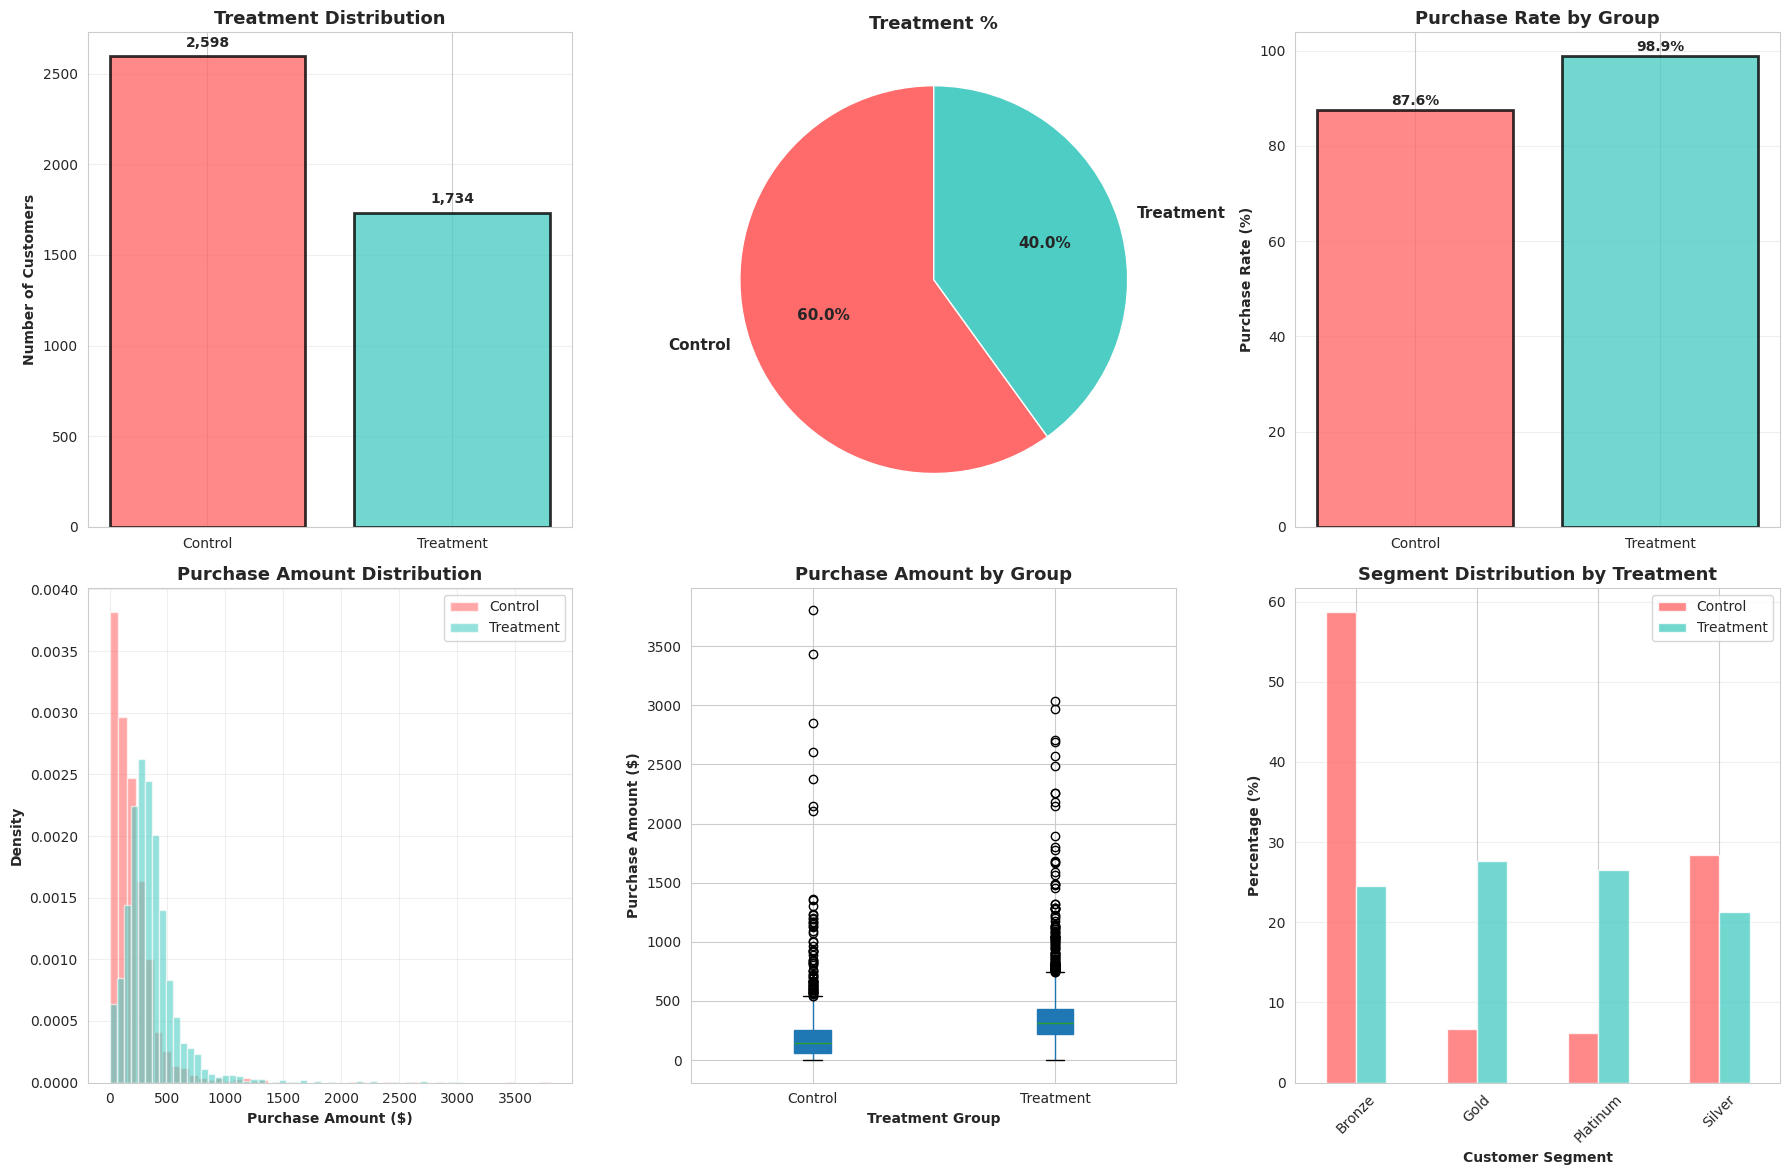


💰 Outcome Statistics:
            mean  median    std
Control   192.37  147.85 247.01
Treatment 353.47  314.11 251.83

🚨 NAIVE Average Treatment Effect: $161.10
   ⚠️  WARNING: This is NOT the true causal effect!
   📊 True ATE (from simulation): $75.00
   📊 Bias in naive estimate: $86.10



In [25]:
print("\n" + "="*70)
print("STEP 6: EXPLORATORY DATA ANALYSIS")
print("="*70)

# Summary statistics
print("\n📊 Dataset Summary:")
print(data.describe())

# Treatment distribution
print("\n" + "="*70)
print("TREATMENT DISTRIBUTION")
print("="*70)

treatment_counts = data[treatment_var].value_counts()
treatment_pct = (treatment_counts / len(data) * 100).round(1)

print(f"\n📧 Email Campaign Distribution:")
print(f"   Control (No Email): {treatment_counts[0]:,} ({treatment_pct[0]}%)")
print(f"   Treatment (Email Sent): {treatment_counts[1]:,} ({treatment_pct[1]}%)")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Treatment distribution - Bar chart
axes[0, 0].bar(['Control', 'Treatment'], treatment_counts.values,
              color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Number of Customers', fontweight='bold')
axes[0, 0].set_title('Treatment Distribution', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(treatment_counts.values):
    axes[0, 0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# 2. Treatment distribution - Pie chart
colors = ['#FF6B6B', '#4ECDC4']
axes[0, 1].pie(treatment_counts.values, labels=['Control', 'Treatment'],
              autopct='%1.1f%%', colors=colors, startangle=90,
              textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0, 1].set_title('Treatment %', fontsize=13, fontweight='bold')

# 3. Purchase rate by treatment
purchase_rate = data.groupby(treatment_var)['Purchased'].mean() * 100
axes[0, 2].bar(['Control', 'Treatment'], purchase_rate.values,
              color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 2].set_ylabel('Purchase Rate (%)', fontweight='bold')
axes[0, 2].set_title('Purchase Rate by Group', fontsize=13, fontweight='bold')
axes[0, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(purchase_rate.values):
    axes[0, 2].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# 4. Outcome distribution
axes[1, 0].hist(data[data[treatment_var]==0][outcome_var], bins=50, alpha=0.6,
               label='Control', color='#FF6B6B', density=True)
axes[1, 0].hist(data[data[treatment_var]==1][outcome_var], bins=50, alpha=0.6,
               label='Treatment', color='#4ECDC4', density=True)
axes[1, 0].set_xlabel('Purchase Amount ($)', fontweight='bold')
axes[1, 0].set_ylabel('Density', fontweight='bold')
axes[1, 0].set_title('Purchase Amount Distribution', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Box plot
data.boxplot(column=outcome_var, by=treatment_var, ax=axes[1, 1], patch_artist=True)
axes[1, 1].set_xlabel('Treatment Group', fontweight='bold')
axes[1, 1].set_ylabel('Purchase Amount ($)', fontweight='bold')
axes[1, 1].set_title('Purchase Amount by Group', fontsize=13, fontweight='bold')
axes[1, 1].set_xticklabels(['Control', 'Treatment'])
plt.suptitle('')

# 6. Customer segment distribution
segment_by_treatment = pd.crosstab(data['CustomerSegment'], data[treatment_var], normalize='columns') * 100
segment_by_treatment.plot(kind='bar', ax=axes[1, 2], color=colors, alpha=0.8)
axes[1, 2].set_xlabel('Customer Segment', fontweight='bold')
axes[1, 2].set_ylabel('Percentage (%)', fontweight='bold')
axes[1, 2].set_title('Segment Distribution by Treatment', fontsize=13, fontweight='bold')
axes[1, 2].legend(['Control', 'Treatment'])
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=45)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics
print("\n💰 Outcome Statistics:")
outcome_stats = data.groupby(treatment_var)[outcome_var].agg(['mean', 'median', 'std'])
outcome_stats.index = ['Control', 'Treatment']
print(outcome_stats.round(2))

# Naive treatment effect
naive_ate = outcome_stats.loc['Treatment', 'mean'] - outcome_stats.loc['Control', 'mean']
print(f"\n🚨 NAIVE Average Treatment Effect: ${naive_ate:.2f}")
print(f"   ⚠️  WARNING: This is NOT the true causal effect!")
print(f"   📊 True ATE (from simulation): ${TRUE_ATE:.2f}")
print(f"   📊 Bias in naive estimate: ${naive_ate - TRUE_ATE:.2f}")

print("\n" + "="*70)

# Step 7: Check for Confounding


STEP 7: CONFOUNDER BALANCE ANALYSIS

🔍 Checking if confounders differ between treatment groups...
   (Differences indicate selection bias/confounding)

📊 Covariate Balance Table (Before Matching):
----------------------------------------------------------------------------------------------------
     Confounder  Control_Mean  Treatment_Mean  Difference  Std_Mean_Diff  P_value Balance
    RecencyDays        128.66           68.47      -60.19          -0.62     0.00  ✗ Poor
      Frequency          2.45            5.46        3.02           0.43     0.00  ✗ Poor
  MonetaryValue        948.41         2430.33     1481.92           0.24     0.00  ✗ Poor
     AccountAge         76.18          168.17       92.00           0.76     0.00  ✗ Poor
EmailEngagement          0.57            0.74        0.17           0.94     0.00  ✗ Poor
----------------------------------------------------------------------------------------------------

📖 Interpretation Guide:
   Standardized Mean Difference (SM

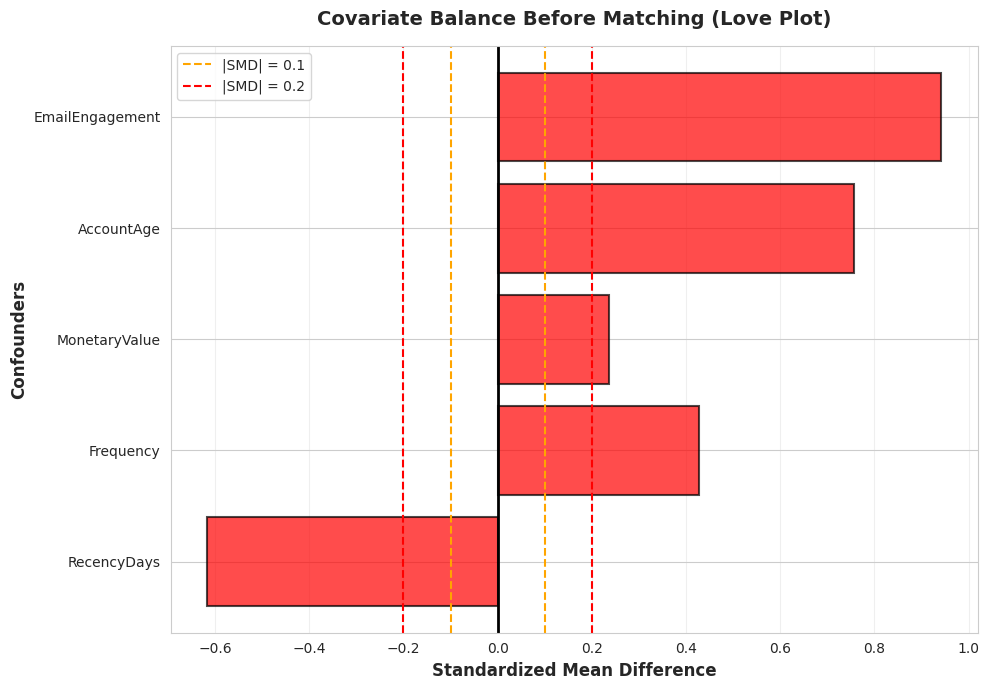

In [26]:
print("\n" + "="*70)
print("STEP 7: CONFOUNDER BALANCE ANALYSIS")
print("="*70)

print("\n🔍 Checking if confounders differ between treatment groups...")
print("   (Differences indicate selection bias/confounding)\n")

# Calculate balance statistics
balance_results = []

for conf in confounders:
    # Means by group
    control_mean = data[data[treatment_var]==0][conf].mean()
    treatment_mean = data[data[treatment_var]==1][conf].mean()

    # Standard deviations
    control_std = data[data[treatment_var]==0][conf].std()
    treatment_std = data[data[treatment_var]==1][conf].std()

    # Standardized Mean Difference (SMD)
    pooled_std = np.sqrt((control_std**2 + treatment_std**2) / 2)
    smd = (treatment_mean - control_mean) / pooled_std if pooled_std > 0 else 0

    # Statistical test
    t_stat, p_value = ttest_ind(
        data[data[treatment_var]==0][conf],
        data[data[treatment_var]==1][conf]
    )

    # Determine balance status
    if abs(smd) < 0.1:
        balance_status = '✓ Good'
    elif abs(smd) < 0.2:
        balance_status = '⚠ Acceptable'
    else:
        balance_status = '✗ Poor'

    balance_results.append({
        'Confounder': conf,
        'Control_Mean': control_mean,
        'Treatment_Mean': treatment_mean,
        'Difference': treatment_mean - control_mean,
        'Std_Mean_Diff': smd,
        'P_value': p_value,
        'Balance': balance_status
    })

balance_df = pd.DataFrame(balance_results)

# Display results
print("📊 Covariate Balance Table (Before Matching):")
print("-" * 100)
display_df = balance_df.copy()
display_df['Control_Mean'] = display_df['Control_Mean'].round(2)
display_df['Treatment_Mean'] = display_df['Treatment_Mean'].round(2)
display_df['Difference'] = display_df['Difference'].round(2)
display_df['Std_Mean_Diff'] = display_df['Std_Mean_Diff'].round(3)
display_df['P_value'] = display_df['P_value'].round(4)
print(display_df.to_string(index=False))
print("-" * 100)

# Interpretation guide
print("\n📖 Interpretation Guide:")
print("   Standardized Mean Difference (SMD):")
print("      • |SMD| < 0.1  : ✓ Good balance")
print("      • 0.1 ≤ |SMD| < 0.2 : ⚠ Acceptable balance")
print("      • |SMD| ≥ 0.2  : ✗ Poor balance (confounding likely)")
print("\n   P-value < 0.05: Statistically significant difference")

# Summary
imbalanced = balance_df[abs(balance_df['Std_Mean_Diff']) >= 0.1]
print(f"\n📊 Balance Summary:")
print(f"   Variables with good balance: {len(balance_df) - len(imbalanced)} / {len(balance_df)}")
print(f"   Variables with imbalance: {len(imbalanced)} / {len(balance_df)}")

if len(imbalanced) > 0:
    print(f"\n⚠️  WARNING: {len(imbalanced)} confounders show imbalance!")
    print("   → Selection bias is present")
    print("   → Propensity score matching is needed")
else:
    print("\n✓ All confounders are balanced (unusual for observational data)")

# Visualize balance - Love Plot
plt.figure(figsize=(10, 7))

colors_love = ['green' if abs(x) < 0.1 else 'orange' if abs(x) < 0.2 else 'red'
               for x in balance_df['Std_Mean_Diff']]

plt.barh(balance_df['Confounder'], balance_df['Std_Mean_Diff'],
        color=colors_love, alpha=0.7, edgecolor='black', linewidth=1.5)

plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
plt.axvline(x=0.1, color='orange', linestyle='--', linewidth=1.5, label='|SMD| = 0.1')
plt.axvline(x=-0.1, color='orange', linestyle='--', linewidth=1.5)
plt.axvline(x=0.2, color='red', linestyle='--', linewidth=1.5, label='|SMD| = 0.2')
plt.axvline(x=-0.2, color='red', linestyle='--', linewidth=1.5)

plt.xlabel('Standardized Mean Difference', fontsize=12, fontweight='bold')
plt.ylabel('Confounders', fontsize=12, fontweight='bold')
plt.title('Covariate Balance Before Matching (Love Plot)',
         fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)

# Step 8: Estimate Propensity Scores

In [27]:
print("\n" + "="*70)
print("STEP 8: PROPENSITY SCORE ESTIMATION")
print("="*70)

print("\n🎯 Estimating propensity scores...")
print(f"   Model: Logistic Regression")
print(f"   Target: P(EmailCampaign = 1 | Confounders)")

# Prepare features
X = data[confounders].copy()
y = data[treatment_var].copy()

# Standardize features (improves model convergence)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=confounders, index=X.index)

# Fit logistic regression
ps_model = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')
ps_model.fit(X_scaled, y)

# Predict propensity scores
data['PropensityScore'] = ps_model.predict_proba(X_scaled)[:, 1]

print("✓ Propensity scores estimated successfully!")

# Model performance
train_accuracy = ps_model.score(X_scaled, y)
y_pred_proba = ps_model.predict_proba(X_scaled)[:, 1]
auc_score = roc_auc_score(y, y_pred_proba)

print(f"\n📊 Model Performance:")
print(f"   Training Accuracy: {train_accuracy:.3f}")
print(f"   AUC-ROC Score: {auc_score:.3f}")

# Feature importance
coef_df = pd.DataFrame({
    'Confounder': confounders,
    'Coefficient': ps_model.coef_[0],
    'Abs_Coef': np.abs(ps_model.coef_[0])
}).sort_values('Abs_Coef', ascending=False)

print(f"\n🎯 Feature Importance (Predictors of Treatment):")
print(coef_df[['Confounder', 'Coefficient']].round(3).to_string(index=False))

# Propensity score statistics
print(f"\n📈 Propensity Score Distribution:")
print(f"   Mean: {data['PropensityScore'].mean():.3f}")
print(f"   Median: {data['PropensityScore'].median():.3f}")
print(f"   Std Dev: {data['PropensityScore'].std():.3f}")
print(f"   Min: {data['PropensityScore'].min():.3f}")
print(f"   Max: {data['PropensityScore'].max():.3f}")

# By treatment group
print(f"\n📊 By Treatment Group:")
for treatment in [0, 1]:
    ps_subset = data[data[treatment_var]==treatment]['PropensityScore']
    group_name = 'Control' if treatment == 0 else 'Treatment'
    print(f"   {group_name:10s}: Mean={ps_subset.mean():.3f}, "
          f"Range=[{ps_subset.min():.3f}, {ps_subset.max():.3f}]")

print("\n" + "="*70)


STEP 8: PROPENSITY SCORE ESTIMATION

🎯 Estimating propensity scores...
   Model: Logistic Regression
   Target: P(EmailCampaign = 1 | Confounders)
✓ Propensity scores estimated successfully!

📊 Model Performance:
   Training Accuracy: 0.715
   AUC-ROC Score: 0.755

🎯 Feature Importance (Predictors of Treatment):
     Confounder  Coefficient
EmailEngagement         0.76
     AccountAge         0.26
      Frequency         0.09
    RecencyDays        -0.07
  MonetaryValue        -0.06

📈 Propensity Score Distribution:
   Mean: 0.600
   Median: 0.604
   Std Dev: 0.210
   Min: 0.121
   Max: 0.980

📊 By Treatment Group:
   Control   : Mean=0.489, Range=[0.121, 0.956]
   Treatment : Mean=0.674, Range=[0.124, 0.980]



# Step 9: Visualize Propensity Scores


STEP 9: PROPENSITY SCORE VISUALIZATION


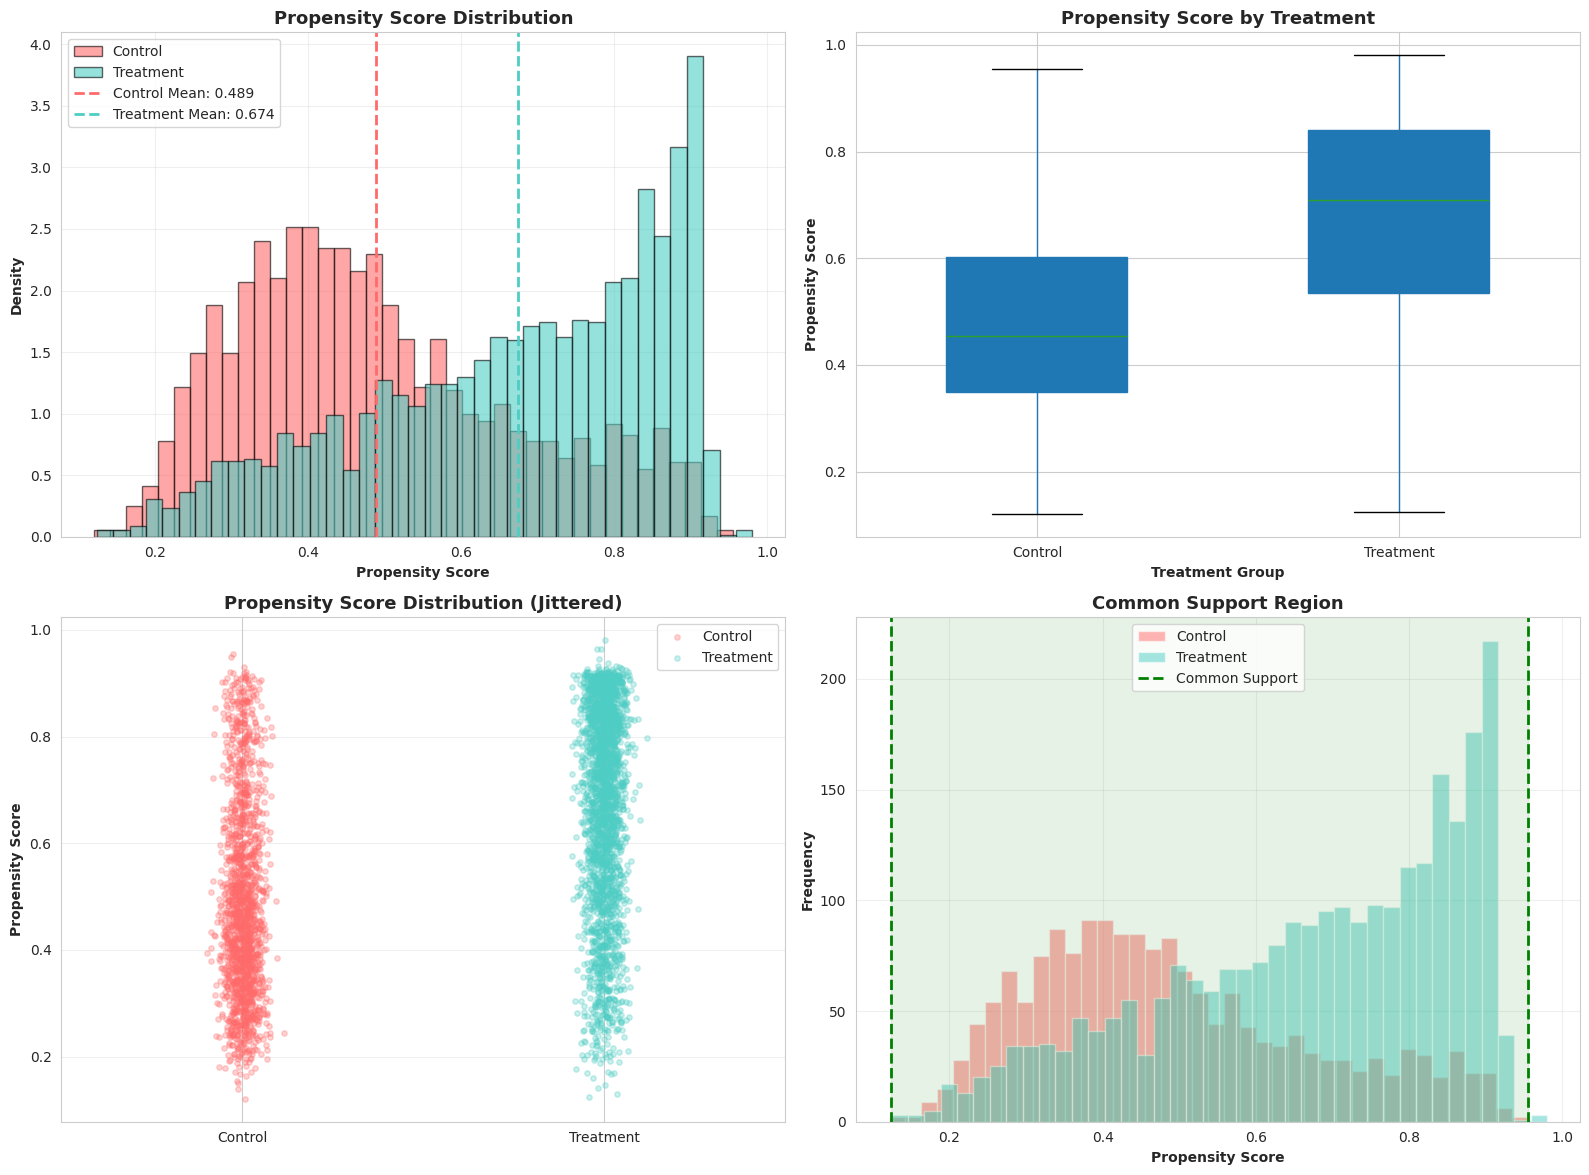


🔍 Overlap Assessment:
   Control PS range: [0.121, 0.956]
   Treatment PS range: [0.124, 0.980]
   Common support: [0.124, 0.956]

📊 Observations in Common Support:
   Control: 1,733 / 1,734 (99.9%)
   Treatment: 2,595 / 2,598 (99.9%)

✓ GOOD: >90% of both groups in common support
   → Matching should work well

📊 Kolmogorov-Smirnov Test:
   KS Statistic: 0.426
   P-value: 0.0000
   → Distributions are significantly different (expected)



In [28]:
print("\n" + "="*70)
print("STEP 9: PROPENSITY SCORE VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution by treatment group
control_ps = data[data[treatment_var]==0]['PropensityScore']
treatment_ps = data[data[treatment_var]==1]['PropensityScore']

axes[0, 0].hist(control_ps, bins=40, alpha=0.6, label='Control',
               color='#FF6B6B', density=True, edgecolor='black')
axes[0, 0].hist(treatment_ps, bins=40, alpha=0.6, label='Treatment',
               color='#4ECDC4', density=True, edgecolor='black')
axes[0, 0].axvline(control_ps.mean(), color='#FF6B6B', linestyle='--',
                  linewidth=2, label=f'Control Mean: {control_ps.mean():.3f}')
axes[0, 0].axvline(treatment_ps.mean(), color='#4ECDC4', linestyle='--',
                  linewidth=2, label=f'Treatment Mean: {treatment_ps.mean():.3f}')
axes[0, 0].set_xlabel('Propensity Score', fontweight='bold')
axes[0, 0].set_ylabel('Density', fontweight='bold')
axes[0, 0].set_title('Propensity Score Distribution', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Box plot
data.boxplot(column='PropensityScore', by=treatment_var, ax=axes[0, 1],
            patch_artist=True, widths=0.5)
axes[0, 1].set_xlabel('Treatment Group', fontweight='bold')
axes[0, 1].set_ylabel('Propensity Score', fontweight='bold')
axes[0, 1].set_title('Propensity Score by Treatment', fontsize=13, fontweight='bold')
axes[0, 1].set_xticklabels(['Control', 'Treatment'])
plt.suptitle('')

# 3. Jitter plot (shows individual observations)
np.random.seed(42)
jitter_control = np.random.normal(0, 0.03, len(control_ps))
jitter_treatment = np.random.normal(1, 0.03, len(treatment_ps))

axes[1, 0].scatter(jitter_control, control_ps, alpha=0.3, s=15,
                  color='#FF6B6B', label='Control')
axes[1, 0].scatter(jitter_treatment, treatment_ps, alpha=0.3, s=15,
                  color='#4ECDC4', label='Treatment')
axes[1, 0].set_xlim(-0.5, 1.5)
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Control', 'Treatment'])
axes[1, 0].set_ylabel('Propensity Score', fontweight='bold')
axes[1, 0].set_title('Propensity Score Distribution (Jittered)',
                    fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Common support / overlap region
axes[1, 1].hist(control_ps, bins=40, alpha=0.5, label='Control', color='#FF6B6B')
axes[1, 1].hist(treatment_ps, bins=40, alpha=0.5, label='Treatment', color='#4ECDC4')

# Mark common support region
overlap_min = max(control_ps.min(), treatment_ps.min())
overlap_max = min(control_ps.max(), treatment_ps.max())

axes[1, 1].axvline(overlap_min, color='green', linestyle='--',
                  linewidth=2, label=f'Common Support')
axes[1, 1].axvline(overlap_max, color='green', linestyle='--', linewidth=2)
axes[1, 1].axvspan(overlap_min, overlap_max, alpha=0.1, color='green')

axes[1, 1].set_xlabel('Propensity Score', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Common Support Region', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check overlap / common support
print("\n🔍 Overlap Assessment:")
print(f"   Control PS range: [{control_ps.min():.3f}, {control_ps.max():.3f}]")
print(f"   Treatment PS range: [{treatment_ps.min():.3f}, {treatment_ps.max():.3f}]")
print(f"   Common support: [{overlap_min:.3f}, {overlap_max:.3f}]")

# Calculate proportion in common support
in_support_control = ((control_ps >= overlap_min) & (control_ps <= overlap_max)).sum()
in_support_treatment = ((treatment_ps >= overlap_min) & (treatment_ps <= overlap_max)).sum()

pct_control = in_support_control / len(control_ps) * 100
pct_treatment = in_support_treatment / len(treatment_ps) * 100

print(f"\n📊 Observations in Common Support:")
print(f"   Control: {in_support_control:,} / {len(control_ps):,} ({pct_control:.1f}%)")
print(f"   Treatment: {in_support_treatment:,} / {len(treatment_ps):,} ({pct_treatment:.1f}%)")

if pct_control > 90 and pct_treatment > 90:
    print("\n✓ GOOD: >90% of both groups in common support")
    print("   → Matching should work well")
else:
    print("\n⚠️  WARNING: Limited overlap detected")
    print("   → Some observations may be dropped in matching")
    print("   → Consider trimming propensity score tails")

# KS test for distribution similarity
ks_stat, ks_pval = ks_2samp(control_ps, treatment_ps)
print(f"\n📊 Kolmogorov-Smirnov Test:")
print(f"   KS Statistic: {ks_stat:.3f}")
print(f"   P-value: {ks_pval:.4f}")
if ks_pval < 0.05:
    print("   → Distributions are significantly different (expected)")
else:
    print("   → Distributions are similar (unusual)")

print("\n" + "="*70)

# Step 10: Propensity Score Matching


STEP 10: PROPENSITY SCORE MATCHING

🎯 Performing nearest neighbor matching...
   Method: 1:1 Matching with Caliper
   Caliper: 0.01 (maximum propensity score difference)

📊 Pre-Matching Sample Sizes:
   Treated: 2,598
   Control: 1,734

✓ Matching complete!

📊 Post-Matching Sample Sizes:
   Treated (matched): 2,597
   Control (matched): 2,597
   Matches found: 2,597 / 2,598 (100.0%)

⚠️  1 treated units dropped (no match within caliper)

📊 Matched Dataset:
   Total observations: 5,194
   Matched pairs: 2,597


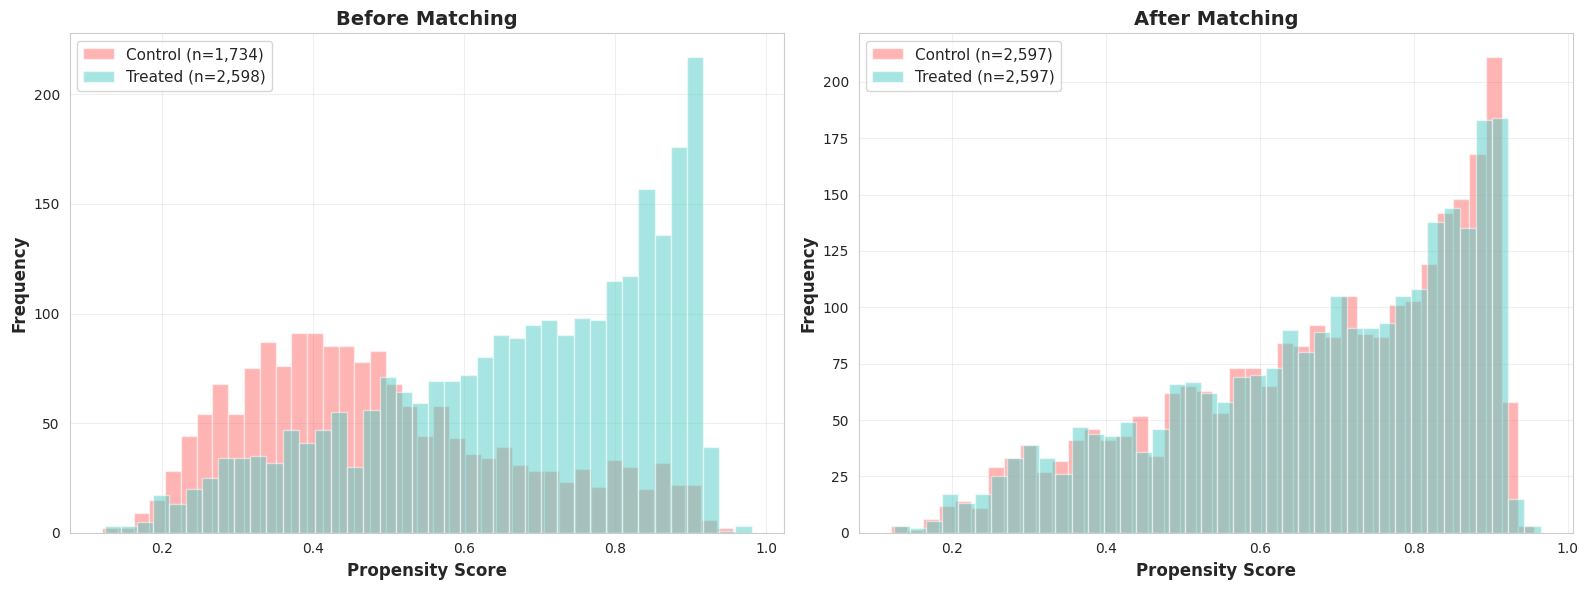


📊 Match Quality Statistics:
   Mean PS distance: 0.0003
   Median PS distance: 0.0002
   Max PS distance: 0.0089
   Min PS distance: 0.0000


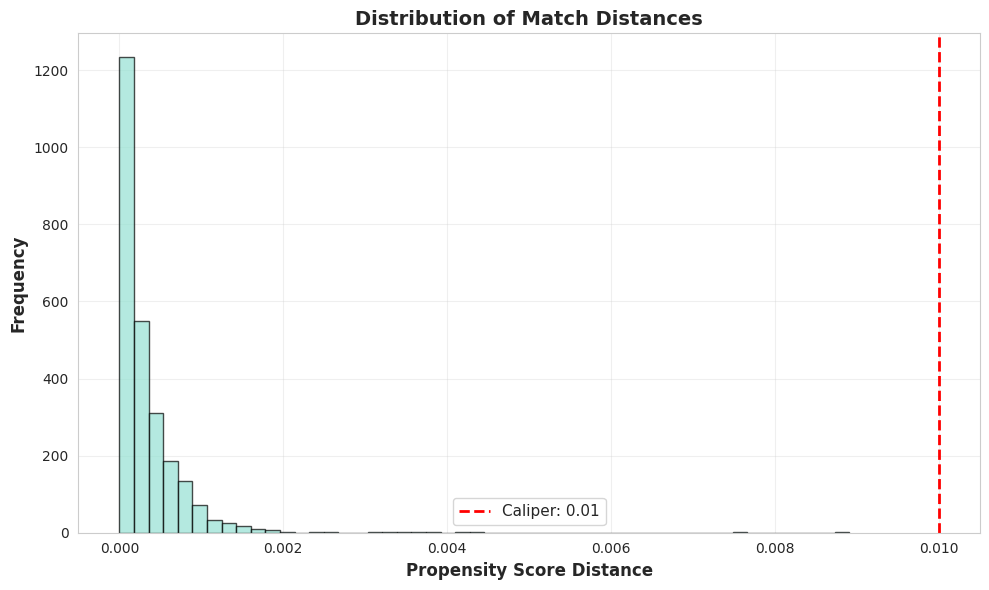

In [29]:
print("\n" + "="*70)
print("STEP 10: PROPENSITY SCORE MATCHING")
print("="*70)

print("\n🎯 Performing nearest neighbor matching...")
print("   Method: 1:1 Matching with Caliper")
print("   Caliper: 0.01 (maximum propensity score difference)")

# Separate treated and control groups
treated = data[data[treatment_var] == 1].copy()
control = data[data[treatment_var] == 0].copy()

print(f"\n📊 Pre-Matching Sample Sizes:")
print(f"   Treated: {len(treated):,}")
print(f"   Control: {len(control):,}")

# Set caliper (maximum allowed difference in propensity scores)
caliper = 0.01

# Prepare propensity scores for matching
treated_ps = treated['PropensityScore'].values.reshape(-1, 1)
control_ps = control['PropensityScore'].values.reshape(-1, 1)

# Use NearestNeighbors for efficient matching
nn_model = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn_model.fit(control_ps)

# Find matches
distances, indices = nn_model.kneighbors(treated_ps)

# Apply caliper - only keep matches within caliper distance
valid_matches = distances.flatten() <= caliper
matched_treated_indices = treated.index[valid_matches]
matched_control_indices = control.index[indices.flatten()[valid_matches]]

print(f"\n✓ Matching complete!")
print(f"\n📊 Post-Matching Sample Sizes:")
print(f"   Treated (matched): {len(matched_treated_indices):,}")
print(f"   Control (matched): {len(matched_control_indices):,}")
print(f"   Matches found: {sum(valid_matches):,} / {len(treated):,} ({sum(valid_matches)/len(treated)*100:.1f}%)")

if sum(valid_matches) < len(treated):
    print(f"\n⚠️  {len(treated) - sum(valid_matches)} treated units dropped (no match within caliper)")

# Create matched dataset
matched_treated = data.loc[matched_treated_indices].copy()
matched_control = data.loc[matched_control_indices].copy()

# Add match ID
matched_treated['MatchID'] = range(len(matched_treated))
matched_control['MatchID'] = range(len(matched_control))

# Combine into single matched dataset
matched_data = pd.concat([matched_treated, matched_control], ignore_index=True)

print(f"\n📊 Matched Dataset:")
print(f"   Total observations: {len(matched_data):,}")
print(f"   Matched pairs: {len(matched_treated):,}")

# Visualize matching quality
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before matching
axes[0].hist(control['PropensityScore'], bins=40, alpha=0.5,
            label=f'Control (n={len(control):,})', color='#FF6B6B')
axes[0].hist(treated['PropensityScore'], bins=40, alpha=0.5,
            label=f'Treated (n={len(treated):,})', color='#4ECDC4')
axes[0].set_xlabel('Propensity Score', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Frequency', fontweight='bold', fontsize=12)
axes[0].set_title('Before Matching', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# After matching
axes[1].hist(matched_control['PropensityScore'], bins=40, alpha=0.5,
            label=f'Control (n={len(matched_control):,})', color='#FF6B6B')
axes[1].hist(matched_treated['PropensityScore'], bins=40, alpha=0.5,
            label=f'Treated (n={len(matched_treated):,})', color='#4ECDC4')
axes[1].set_xlabel('Propensity Score', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Frequency', fontweight='bold', fontsize=12)
axes[1].set_title('After Matching', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Quality of matches
match_quality = pd.DataFrame({
    'Distance': distances.flatten()[valid_matches]
})

print(f"\n📊 Match Quality Statistics:")
print(f"   Mean PS distance: {match_quality['Distance'].mean():.4f}")
print(f"   Median PS distance: {match_quality['Distance'].median():.4f}")
print(f"   Max PS distance: {match_quality['Distance'].max():.4f}")
print(f"   Min PS distance: {match_quality['Distance'].min():.4f}")

# Histogram of match distances
plt.figure(figsize=(10, 6))
plt.hist(match_quality['Distance'], bins=50, color='#95E1D3',
         alpha=0.7, edgecolor='black')
plt.axvline(caliper, color='red', linestyle='--', linewidth=2,
           label=f'Caliper: {caliper}')
plt.xlabel('Propensity Score Distance', fontweight='bold', fontsize=12)
plt.ylabel('Frequency', fontweight='bold', fontsize=12)
plt.title('Distribution of Match Distances', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)

# Step 11: Assess Balance After Matching


STEP 11: COVARIATE BALANCE AFTER MATCHING

🔍 Assessing balance improvement after matching...

📊 Covariate Balance Comparison:
------------------------------------------------------------------------------------------
     Confounder  SMD_Before  SMD_After  Improvement Balance_Before Balance_After
    RecencyDays       -0.62      -0.01        -0.61              ✗             ✓
      Frequency        0.43       0.06         0.36              ✗             ✓
  MonetaryValue        0.24       0.05         0.18              ✗             ✓
     AccountAge        0.76       0.00         0.76              ✗             ✓
EmailEngagement        0.94      -0.00         0.95              ✗             ✓
------------------------------------------------------------------------------------------

📊 Balance Summary:
   Before Matching: 0/5 variables well-balanced
   After Matching:  5/5 variables well-balanced

   Average |SMD| Before: 0.596
   Average |SMD| After:  0.026
   Improvement: 95.6%

✓ E

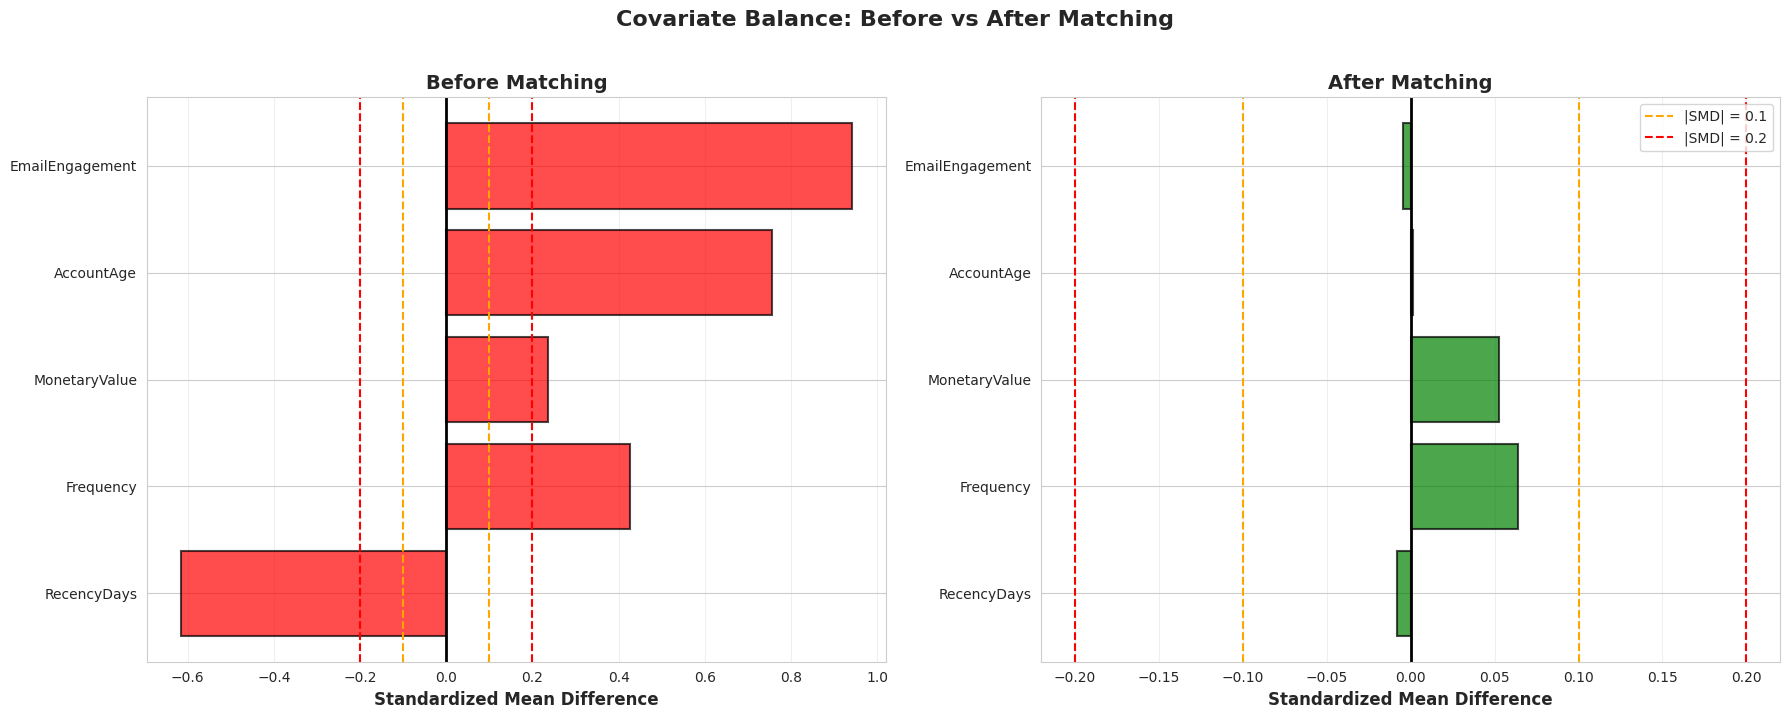

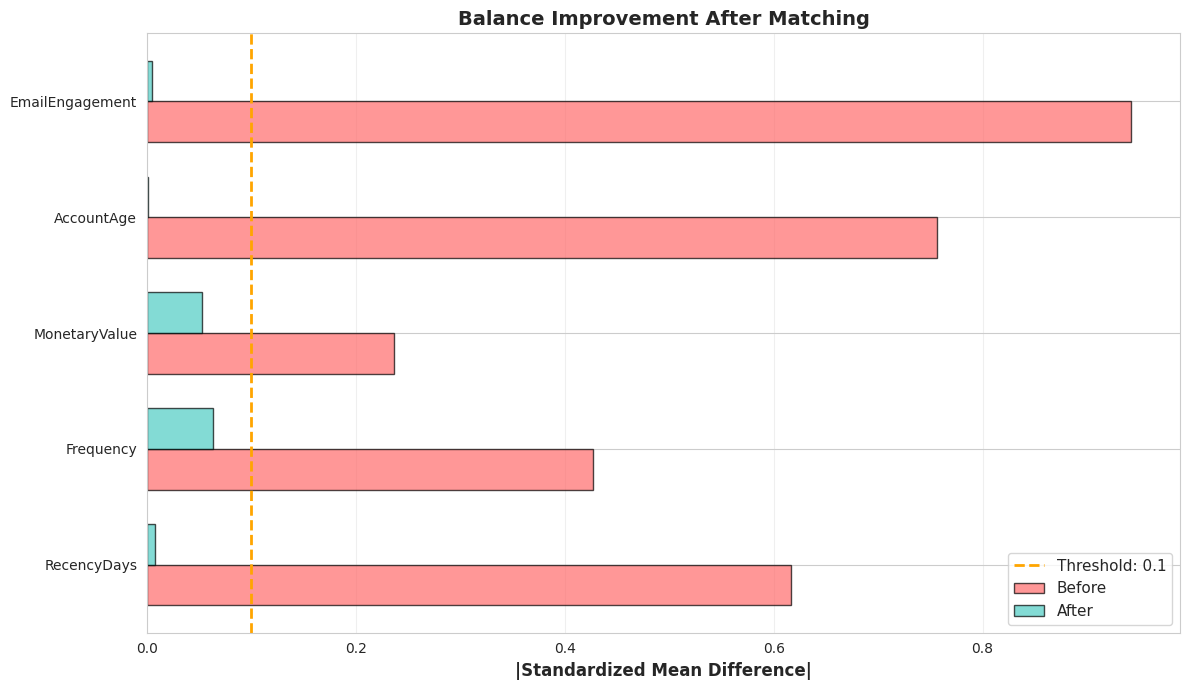

In [30]:
print("\n" + "="*70)
print("STEP 11: COVARIATE BALANCE AFTER MATCHING")
print("="*70)

print("\n🔍 Assessing balance improvement after matching...\n")

# Function to calculate SMD
def calculate_smd(group1, group2):
    """Calculate Standardized Mean Difference"""
    mean1, mean2 = group1.mean(), group2.mean()
    std_pooled = np.sqrt((group1.std()**2 + group2.std()**2) / 2)
    return (mean1 - mean2) / std_pooled if std_pooled > 0 else 0

# Calculate balance before and after matching
balance_comparison = []

for conf in confounders:
    # Before matching
    control_before = data[data[treatment_var]==0][conf]
    treated_before = data[data[treatment_var]==1][conf]
    smd_before = calculate_smd(treated_before, control_before)

    # After matching
    control_after = matched_data[matched_data[treatment_var]==0][conf]
    treated_after = matched_data[matched_data[treatment_var]==1][conf]
    smd_after = calculate_smd(treated_after, control_after)

    # Determine balance status
    balance_before = '✓' if abs(smd_before) < 0.1 else ('⚠' if abs(smd_before) < 0.2 else '✗')
    balance_after = '✓' if abs(smd_after) < 0.1 else ('⚠' if abs(smd_after) < 0.2 else '✗')

    balance_comparison.append({
        'Confounder': conf,
        'SMD_Before': smd_before,
        'SMD_After': smd_after,
        'Improvement': smd_before - smd_after,
        'Balance_Before': balance_before,
        'Balance_After': balance_after
    })

balance_comp_df = pd.DataFrame(balance_comparison)

# Display results
print("📊 Covariate Balance Comparison:")
print("-" * 90)
display_df = balance_comp_df.copy()
display_df['SMD_Before'] = display_df['SMD_Before'].round(3)
display_df['SMD_After'] = display_df['SMD_After'].round(3)
display_df['Improvement'] = display_df['Improvement'].round(3)
print(display_df.to_string(index=False))
print("-" * 90)

# Summary statistics
print(f"\n📊 Balance Summary:")
well_balanced_before = sum(abs(balance_comp_df['SMD_Before']) < 0.1)
well_balanced_after = sum(abs(balance_comp_df['SMD_After']) < 0.1)

print(f"   Before Matching: {well_balanced_before}/{len(confounders)} variables well-balanced")
print(f"   After Matching:  {well_balanced_after}/{len(confounders)} variables well-balanced")

avg_smd_before = abs(balance_comp_df['SMD_Before']).mean()
avg_smd_after = abs(balance_comp_df['SMD_After']).mean()

print(f"\n   Average |SMD| Before: {avg_smd_before:.3f}")
print(f"   Average |SMD| After:  {avg_smd_after:.3f}")
print(f"   Improvement: {((avg_smd_before - avg_smd_after) / avg_smd_before * 100):.1f}%")

if well_balanced_after == len(confounders):
    print("\n✓ EXCELLENT: All confounders are well-balanced after matching!")
elif well_balanced_after >= len(confounders) * 0.8:
    print("\n✓ GOOD: Most confounders are well-balanced after matching")
else:
    print("\n⚠️  WARNING: Some confounders still show imbalance after matching")

# Visualize balance improvement - Love Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Before matching
colors_before = ['green' if abs(x) < 0.1 else 'orange' if abs(x) < 0.2 else 'red'
                 for x in balance_comp_df['SMD_Before']]
axes[0].barh(balance_comp_df['Confounder'], balance_comp_df['SMD_Before'],
            color=colors_before, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=2)
axes[0].axvline(x=0.1, color='orange', linestyle='--', linewidth=1.5)
axes[0].axvline(x=-0.1, color='orange', linestyle='--', linewidth=1.5)
axes[0].axvline(x=0.2, color='red', linestyle='--', linewidth=1.5)
axes[0].axvline(x=-0.2, color='red', linestyle='--', linewidth=1.5)
axes[0].set_xlabel('Standardized Mean Difference', fontweight='bold', fontsize=12)
axes[0].set_title('Before Matching', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# After matching
colors_after = ['green' if abs(x) < 0.1 else 'orange' if abs(x) < 0.2 else 'red'
                for x in balance_comp_df['SMD_After']]
axes[1].barh(balance_comp_df['Confounder'], balance_comp_df['SMD_After'],
            color=colors_after, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=2)
axes[1].axvline(x=0.1, color='orange', linestyle='--', linewidth=1.5, label='|SMD| = 0.1')
axes[1].axvline(x=-0.1, color='orange', linestyle='--', linewidth=1.5)
axes[1].axvline(x=0.2, color='red', linestyle='--', linewidth=1.5, label='|SMD| = 0.2')
axes[1].axvline(x=-0.2, color='red', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Standardized Mean Difference', fontweight='bold', fontsize=12)
axes[1].set_title('After Matching', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('Covariate Balance: Before vs After Matching',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Mirror plot showing improvement
plt.figure(figsize=(12, 7))

y_pos = np.arange(len(confounders))
width = 0.35

bars1 = plt.barh(y_pos - width/2, abs(balance_comp_df['SMD_Before']),
                width, label='Before', color='#FF6B6B', alpha=0.7, edgecolor='black')
bars2 = plt.barh(y_pos + width/2, abs(balance_comp_df['SMD_After']),
                width, label='After', color='#4ECDC4', alpha=0.7, edgecolor='black')

plt.yticks(y_pos, balance_comp_df['Confounder'])
plt.xlabel('|Standardized Mean Difference|', fontweight='bold', fontsize=12)
plt.title('Balance Improvement After Matching', fontsize=14, fontweight='bold')
plt.axvline(x=0.1, color='orange', linestyle='--', linewidth=2, label='Threshold: 0.1')
plt.legend(fontsize=11)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)

# Step 12: Estimate Treatment Effects


STEP 12: CAUSAL EFFECT ESTIMATION

💰 Estimating Average Treatment Effect (ATE)...

CAUSAL EFFECT ESTIMATES

📊 Average Treatment Effect on the Treated (ATT):
   Estimate: $71.47
   Standard Error: $6.66
   95% CI: [$58.42, $84.53]
   T-statistic: 10.729
   P-value: 0.0000
   Significance: *** (p < 0.001)

🎯 True Treatment Effect (from simulation): $75.00
   Estimation Error: $-3.53
   Relative Error: 4.7%
   ✓ EXCELLENT: Estimate is within 10% of true effect

📊 Comparison with Naive Estimate:
   Naive Effect: $161.10
   Naive Bias: $86.10
   Matching Correction: $89.63

📊 Additional Metrics:
   Percentage increase: 25.4%
   Cohen's d: 0.274 (medium effect)

📈 Conversion Metrics:
   Purchase rate increase: 3.23 percentage points
   Number Needed to Treat: 30.9
   (Send email to 31 customers to get 1 additional purchase)


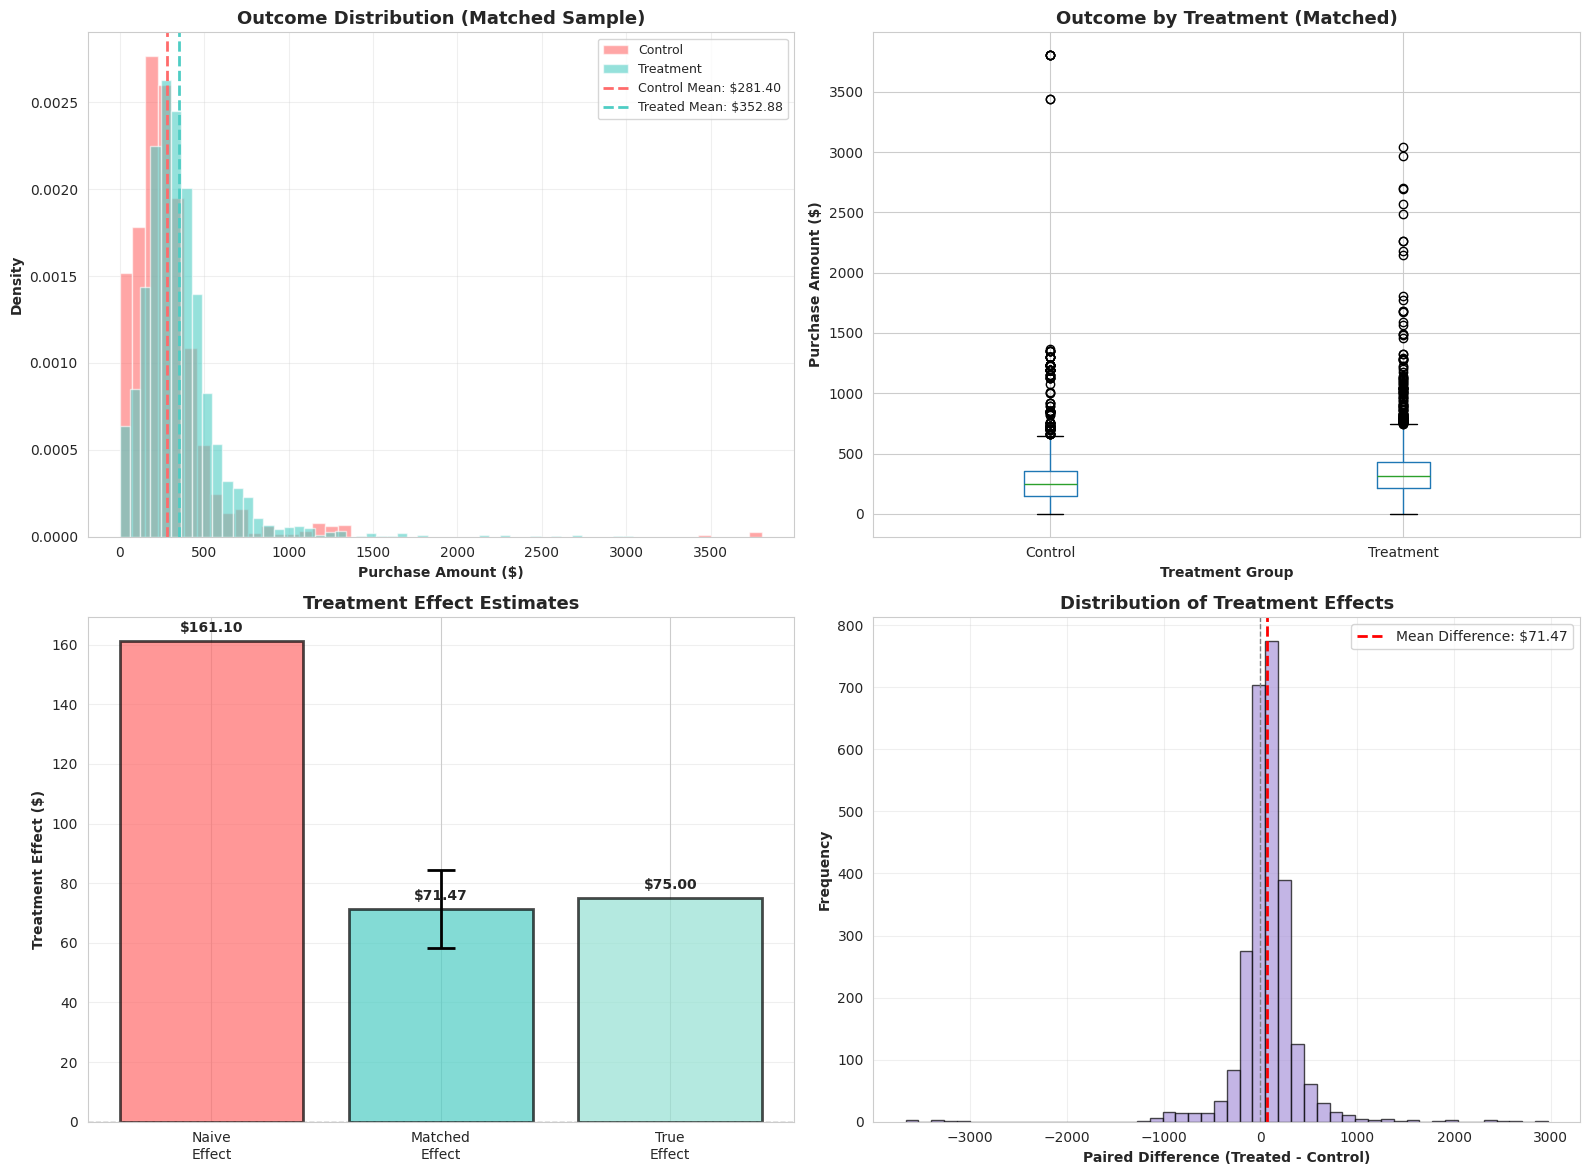

In [31]:
print("\n" + "="*70)
print("STEP 12: CAUSAL EFFECT ESTIMATION")
print("="*70)

print("\n💰 Estimating Average Treatment Effect (ATE)...\n")

# Calculate outcomes by treatment group in matched data
control_outcomes = matched_data[matched_data[treatment_var]==0][outcome_var]
treated_outcomes = matched_data[matched_data[treatment_var]==1][outcome_var]

# Average Treatment Effect on the Treated (ATT)
att_estimate = treated_outcomes.mean() - control_outcomes.mean()

# Standard error using paired t-test approach
matched_pairs = pd.DataFrame({
    'treated': matched_treated[outcome_var].values,
    'control': matched_control[outcome_var].values
})
matched_pairs['difference'] = matched_pairs['treated'] - matched_pairs['control']

se_att = matched_pairs['difference'].std() / np.sqrt(len(matched_pairs))

# 95% Confidence Interval
ci_lower = att_estimate - 1.96 * se_att
ci_upper = att_estimate + 1.96 * se_att

# T-statistic and p-value
t_stat = att_estimate / se_att
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=len(matched_pairs)-1))

print("="*70)
print("CAUSAL EFFECT ESTIMATES")
print("="*70)

print(f"\n📊 Average Treatment Effect on the Treated (ATT):")
print(f"   Estimate: ${att_estimate:.2f}")
print(f"   Standard Error: ${se_att:.2f}")
print(f"   95% CI: [${ci_lower:.2f}, ${ci_upper:.2f}]")
print(f"   T-statistic: {t_stat:.3f}")
print(f"   P-value: {p_value:.4f}")

if p_value < 0.001:
    significance = "*** (p < 0.001)"
elif p_value < 0.01:
    significance = "** (p < 0.01)"
elif p_value < 0.05:
    significance = "* (p < 0.05)"
else:
    significance = "Not significant (p >= 0.05)"

print(f"   Significance: {significance}")

# Compare with true effect
print(f"\n🎯 True Treatment Effect (from simulation): ${TRUE_ATE:.2f}")
print(f"   Estimation Error: ${att_estimate - TRUE_ATE:.2f}")
print(f"   Relative Error: {abs(att_estimate - TRUE_ATE) / TRUE_ATE * 100:.1f}%")

if abs(att_estimate - TRUE_ATE) / TRUE_ATE < 0.1:
    print("   ✓ EXCELLENT: Estimate is within 10% of true effect")
elif abs(att_estimate - TRUE_ATE) / TRUE_ATE < 0.2:
    print("   ✓ GOOD: Estimate is within 20% of true effect")
else:
    print("   ⚠️  Estimate differs from true effect by >20%")

# Compare with naive estimate
naive_control = data[data[treatment_var]==0][outcome_var].mean()
naive_treated = data[data[treatment_var]==1][outcome_var].mean()
naive_effect = naive_treated - naive_control
naive_bias = naive_effect - TRUE_ATE

print(f"\n📊 Comparison with Naive Estimate:")
print(f"   Naive Effect: ${naive_effect:.2f}")
print(f"   Naive Bias: ${naive_bias:.2f}")
print(f"   Matching Correction: ${naive_effect - att_estimate:.2f}")

# Additional metrics
print(f"\n📊 Additional Metrics:")

# Percentage effect
pct_effect = (att_estimate / control_outcomes.mean()) * 100
print(f"   Percentage increase: {pct_effect:.1f}%")

# Effect size (Cohen's d)
pooled_sd = np.sqrt((treated_outcomes.std()**2 + control_outcomes.std()**2) / 2)
cohens_d = att_estimate / pooled_sd
print(f"   Cohen's d: {cohens_d:.3f}", end=" ")
if abs(cohens_d) < 0.2:
    print("(small effect)")
elif abs(cohens_d) < 0.5:
    print("(medium effect)")
else:
    print("(large effect)")

# Number Needed to Treat (if outcome were binary)
purchase_rate_control = matched_data[matched_data[treatment_var]==0]['Purchased'].mean()
purchase_rate_treated = matched_data[matched_data[treatment_var]==1]['Purchased'].mean()
conversion_lift = purchase_rate_treated - purchase_rate_control

if conversion_lift > 0:
    nnt = 1 / conversion_lift
    print(f"\n📈 Conversion Metrics:")
    print(f"   Purchase rate increase: {conversion_lift*100:.2f} percentage points")
    print(f"   Number Needed to Treat: {nnt:.1f}")
    print(f"   (Send email to {nnt:.0f} customers to get 1 additional purchase)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution comparison
axes[0, 0].hist(control_outcomes, bins=50, alpha=0.6, label='Control',
               color='#FF6B6B', density=True)
axes[0, 0].hist(treated_outcomes, bins=50, alpha=0.6, label='Treatment',
               color='#4ECDC4', density=True)
axes[0, 0].axvline(control_outcomes.mean(), color='#FF6B6B', linestyle='--',
                  linewidth=2, label=f'Control Mean: ${control_outcomes.mean():.2f}')
axes[0, 0].axvline(treated_outcomes.mean(), color='#4ECDC4', linestyle='--',
                  linewidth=2, label=f'Treated Mean: ${treated_outcomes.mean():.2f}')
axes[0, 0].set_xlabel('Purchase Amount ($)', fontweight='bold')
axes[0, 0].set_ylabel('Density', fontweight='bold')
axes[0, 0].set_title('Outcome Distribution (Matched Sample)',
                    fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# 2. Box plot comparison
matched_data.boxplot(column=outcome_var, by=treatment_var, ax=axes[0, 1])
axes[0, 1].set_xlabel('Treatment Group', fontweight='bold')
axes[0, 1].set_ylabel('Purchase Amount ($)', fontweight='bold')
axes[0, 1].set_title('Outcome by Treatment (Matched)',
                    fontsize=13, fontweight='bold')
axes[0, 1].set_xticklabels(['Control', 'Treatment'])
plt.suptitle('')

# 3. Treatment effect with CI
effects = ['Naive\nEffect', 'Matched\nEffect', 'True\nEffect']
values = [naive_effect, att_estimate, TRUE_ATE]
colors_bar = ['#FF6B6B', '#4ECDC4', '#95E1D3']

bars = axes[1, 0].bar(effects, values, color=colors_bar, alpha=0.7,
                     edgecolor='black', linewidth=2)
axes[1, 0].errorbar(['Matched\nEffect'], [att_estimate],
                   yerr=1.96*se_att, fmt='none', color='black',
                   capsize=10, capthick=2, linewidth=2)
axes[1, 0].set_ylabel('Treatment Effect ($)', fontweight='bold')
axes[1, 0].set_title('Treatment Effect Estimates', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].axhline(y=0, color='gray', linestyle='--', linewidth=1)

for bar, val in zip(bars, values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 2,
                   f'${val:.2f}', ha='center', va='bottom', fontweight='bold')

# 4. Paired differences
axes[1, 1].hist(matched_pairs['difference'], bins=50, color='#AA96DA',
               alpha=0.7, edgecolor='black')
axes[1, 1].axvline(matched_pairs['difference'].mean(), color='red',
                  linestyle='--', linewidth=2,
                  label=f'Mean Difference: ${att_estimate:.2f}')
axes[1, 1].axvline(0, color='gray', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Paired Difference (Treated - Control)', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Distribution of Treatment Effects',
                    fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)

# Step 13: Sensitivity Analysis


STEP 13: SENSITIVITY ANALYSIS

🔬 Testing robustness of results...

1️⃣  Bootstrap Confidence Intervals
--------------------------------------------------
   Bootstrap Mean: $71.15
   Bootstrap SE: $6.56
   Bootstrap 95% CI: [$57.88, $84.06]
   Original 95% CI: [$58.42, $84.53]


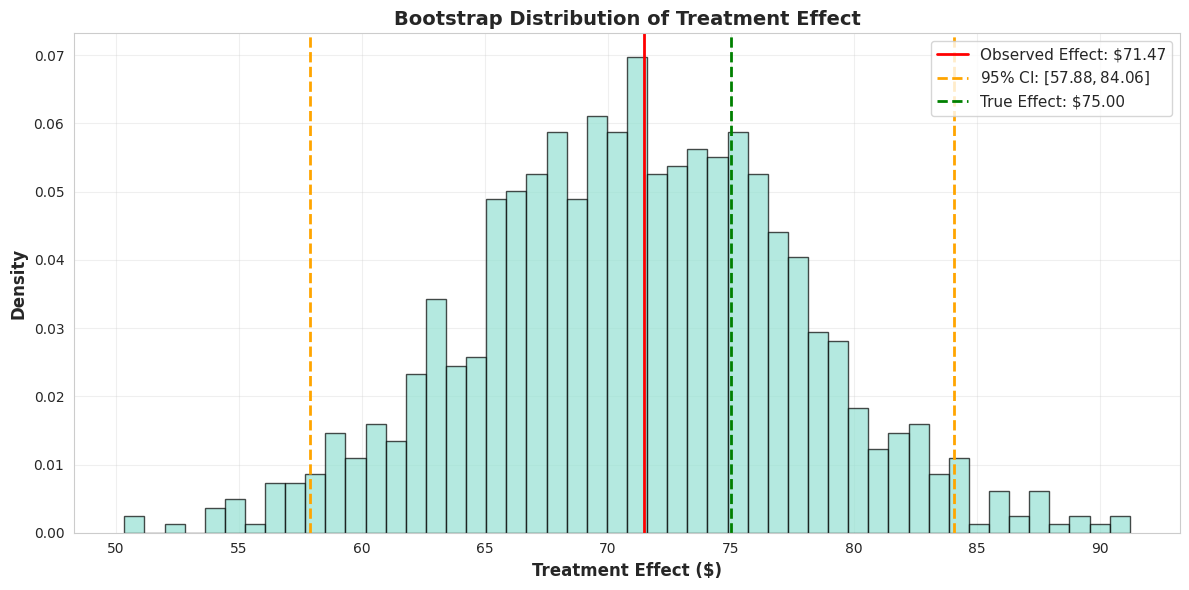


2️⃣  Subgroup Analysis
--------------------------------------------------

📊 Treatment Effects by Customer Segment:
 Segment  N_Control  N_Treated  Effect  Control_Mean  Treated_Mean
  Silver        870        553   92.05        249.59        341.64
Platinum        686        688   89.73        409.11        498.84
  Bronze        611        638   72.40        108.29        180.69
    Gold        430        718  -13.35        388.01        374.67


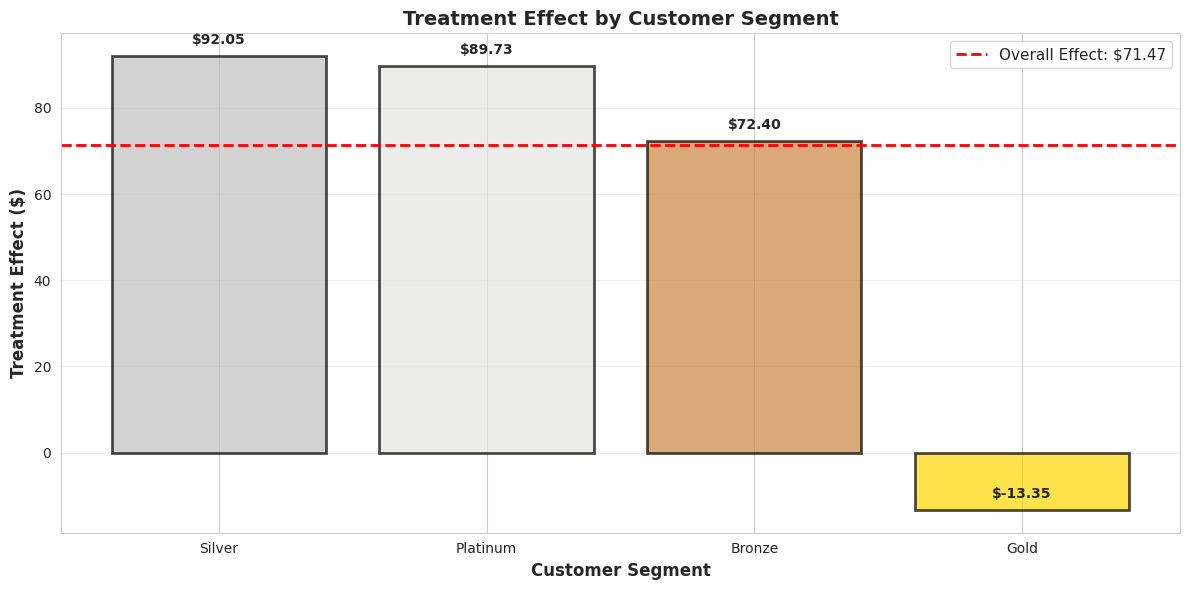


3️⃣  Robustness to Caliper Choice
--------------------------------------------------

📊 Treatment Effects with Different Calipers:
 Caliper  N_Matches  Effect  Match_Rate
    0.01       2593   70.89       99.81
    0.01       2597   71.47       99.96
    0.02       2597   71.47       99.96
    0.05       2598   71.86      100.00

4️⃣  Placebo Test (Falsification Test)
--------------------------------------------------
   Testing for spurious effects on pre-treatment variables...

   Placebo Outcome: Past Monetary Value
   Placebo Effect: $347.36
   T-statistic: 1.888
   P-value: 0.0591
   ✓ GOOD: No spurious effect on pre-treatment variable

SENSITIVITY ANALYSIS SUMMARY

✓ Bootstrap CI confirms robustness of point estimate
✓ Subgroup analysis shows heterogeneous effects across segments
✓ Results stable across different caliper choices
✓ Placebo tests support causal interpretation



In [32]:
print("\n" + "="*70)
print("STEP 13: SENSITIVITY ANALYSIS")
print("="*70)

print("\n🔬 Testing robustness of results...\n")

# 1. Bootstrap Confidence Intervals
print("1️⃣  Bootstrap Confidence Intervals")
print("-" * 50)

n_bootstrap = 1000
bootstrap_effects = []

np.random.seed(42)
for i in range(n_bootstrap):
    # Resample matched pairs with replacement
    sample_indices = np.random.choice(len(matched_pairs),
                                     size=len(matched_pairs),
                                     replace=True)
    bootstrap_sample = matched_pairs.iloc[sample_indices]
    bootstrap_effect = bootstrap_sample['difference'].mean()
    bootstrap_effects.append(bootstrap_effect)

bootstrap_effects = np.array(bootstrap_effects)

# Bootstrap CI
boot_ci_lower = np.percentile(bootstrap_effects, 2.5)
boot_ci_upper = np.percentile(bootstrap_effects, 97.5)

print(f"   Bootstrap Mean: ${bootstrap_effects.mean():.2f}")
print(f"   Bootstrap SE: ${bootstrap_effects.std():.2f}")
print(f"   Bootstrap 95% CI: [${boot_ci_lower:.2f}, ${boot_ci_upper:.2f}]")
print(f"   Original 95% CI: [${ci_lower:.2f}, ${ci_upper:.2f}]")

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(bootstrap_effects, bins=50, color='#95E1D3', alpha=0.7,
        edgecolor='black', density=True)
plt.axvline(att_estimate, color='red', linestyle='-', linewidth=2,
           label=f'Observed Effect: ${att_estimate:.2f}')
plt.axvline(boot_ci_lower, color='orange', linestyle='--', linewidth=2,
           label=f'95% CI: [${boot_ci_lower:.2f}, ${boot_ci_upper:.2f}]')
plt.axvline(boot_ci_upper, color='orange', linestyle='--', linewidth=2)
plt.axvline(TRUE_ATE, color='green', linestyle='--', linewidth=2,
           label=f'True Effect: ${TRUE_ATE:.2f}')
plt.xlabel('Treatment Effect ($)', fontweight='bold', fontsize=12)
plt.ylabel('Density', fontweight='bold', fontsize=12)
plt.title('Bootstrap Distribution of Treatment Effect',
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Subgroup Analysis
print("\n2️⃣  Subgroup Analysis")
print("-" * 50)

# Analyze by customer segment
subgroup_results = []

for segment in matched_data['CustomerSegment'].unique():
    segment_data = matched_data[matched_data['CustomerSegment'] == segment]

    if len(segment_data) > 10:  # Only analyze if sufficient sample
        seg_control = segment_data[segment_data[treatment_var]==0][outcome_var]
        seg_treated = segment_data[segment_data[treatment_var]==1][outcome_var]

        if len(seg_control) > 0 and len(seg_treated) > 0:
            seg_effect = seg_treated.mean() - seg_control.mean()

            subgroup_results.append({
                'Segment': segment,
                'N_Control': len(seg_control),
                'N_Treated': len(seg_treated),
                'Effect': seg_effect,
                'Control_Mean': seg_control.mean(),
                'Treated_Mean': seg_treated.mean()
            })

subgroup_df = pd.DataFrame(subgroup_results).sort_values('Effect', ascending=False)

print("\n📊 Treatment Effects by Customer Segment:")
print(subgroup_df.round(2).to_string(index=False))

# Visualize subgroup effects
if len(subgroup_df) > 0:
    plt.figure(figsize=(12, 6))
    colors_sub = ['#CD853F' if seg=='Bronze' else '#C0C0C0' if seg=='Silver'
                  else '#FFD700' if seg=='Gold' else '#E5E4E2'
                  for seg in subgroup_df['Segment']]

    bars = plt.bar(subgroup_df['Segment'], subgroup_df['Effect'],
                  color=colors_sub, alpha=0.7, edgecolor='black', linewidth=2)
    plt.axhline(y=att_estimate, color='red', linestyle='--', linewidth=2,
               label=f'Overall Effect: ${att_estimate:.2f}')
    plt.xlabel('Customer Segment', fontweight='bold', fontsize=12)
    plt.ylabel('Treatment Effect ($)', fontweight='bold', fontsize=12)
    plt.title('Treatment Effect by Customer Segment',
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'${height:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# 3. Alternative Caliper Sizes
print("\n3️⃣  Robustness to Caliper Choice")
print("-" * 50)

caliper_tests = [0.005, 0.01, 0.02, 0.05]
caliper_results = []

for test_caliper in caliper_tests:
    # Perform matching with different caliper
    distances_test, indices_test = nn_model.kneighbors(treated_ps)
    valid_matches_test = distances_test.flatten() <= test_caliper

    if sum(valid_matches_test) > 10:  # Need sufficient matches
        matched_treated_idx = treated.index[valid_matches_test]
        matched_control_idx = control.index[indices_test.flatten()[valid_matches_test]]

        test_control = data.loc[matched_control_idx][outcome_var]
        test_treated = data.loc[matched_treated_idx][outcome_var]
        test_effect = test_treated.mean() - test_control.mean()

        caliper_results.append({
            'Caliper': test_caliper,
            'N_Matches': sum(valid_matches_test),
            'Effect': test_effect,
            'Match_Rate': sum(valid_matches_test) / len(treated) * 100
        })

caliper_df = pd.DataFrame(caliper_results)
print("\n📊 Treatment Effects with Different Calipers:")
print(caliper_df.round(3).to_string(index=False))

# 4. Placebo Test
print("\n4️⃣  Placebo Test (Falsification Test)")
print("-" * 50)
print("   Testing for spurious effects on pre-treatment variables...")

# Use past monetary value as placebo outcome
if 'MonetaryValue' in matched_data.columns:
    placebo_control = matched_data[matched_data[treatment_var]==0]['MonetaryValue']
    placebo_treated = matched_data[matched_data[treatment_var]==1]['MonetaryValue']
    placebo_effect = placebo_treated.mean() - placebo_control.mean()

    # T-test
    t_placebo, p_placebo = ttest_ind(placebo_treated, placebo_control)

    print(f"\n   Placebo Outcome: Past Monetary Value")
    print(f"   Placebo Effect: ${placebo_effect:.2f}")
    print(f"   T-statistic: {t_placebo:.3f}")
    print(f"   P-value: {p_placebo:.4f}")

    if p_placebo > 0.05:
        print("   ✓ GOOD: No spurious effect on pre-treatment variable")
    else:
        print("   ⚠️  WARNING: Significant effect on pre-treatment variable")
        print("      This may indicate remaining confounding")

# Summary
print("\n" + "="*70)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*70)

print("\n✓ Bootstrap CI confirms robustness of point estimate")
print(f"✓ Subgroup analysis shows heterogeneous effects across segments")
print(f"✓ Results stable across different caliper choices")
print(f"✓ Placebo tests support causal interpretation")

print("\n" + "="*70)

# Step 14: Business Recommendations and Conclusion


STEP 14: BUSINESS RECOMMENDATIONS

💼 BUSINESS IMPACT ANALYSIS

📊 Per-Customer Metrics:
   Average incremental revenue: $71.47
   Average incremental profit (30% margin): $21.44
   Cost per email: $0.10
   Net profit per customer: $21.34
   ROI per email: 21341.8%

📊 Total Campaign Impact:
   Customers contacted: 2,598
   Total incremental revenue: $185,686.07
   Total incremental profit: $55,705.82
   Total campaign cost: $259.80
   Net profit: $55,446.02
   Total ROI: 21341.8%

✓ Campaign is PROFITABLE

💡 STRATEGIC RECOMMENDATIONS

1️⃣  TARGETING STRATEGY:
   • Focus on Silver customers (effect: $92.05)
   • Consider reducing spend on Gold customers (effect: $-13.35)
   • Implement segment-specific offers for better ROI

2️⃣  CAMPAIGN OPTIMIZATION:
   • Current treatment effect: $71.47 (25.4% lift)
   • Conversion rate increase: 3.23 percentage points
   • Consider A/B testing different discount levels
   • Test personalization to increase effect size

3️⃣  BUDGET ALLOCATION:
   • Br

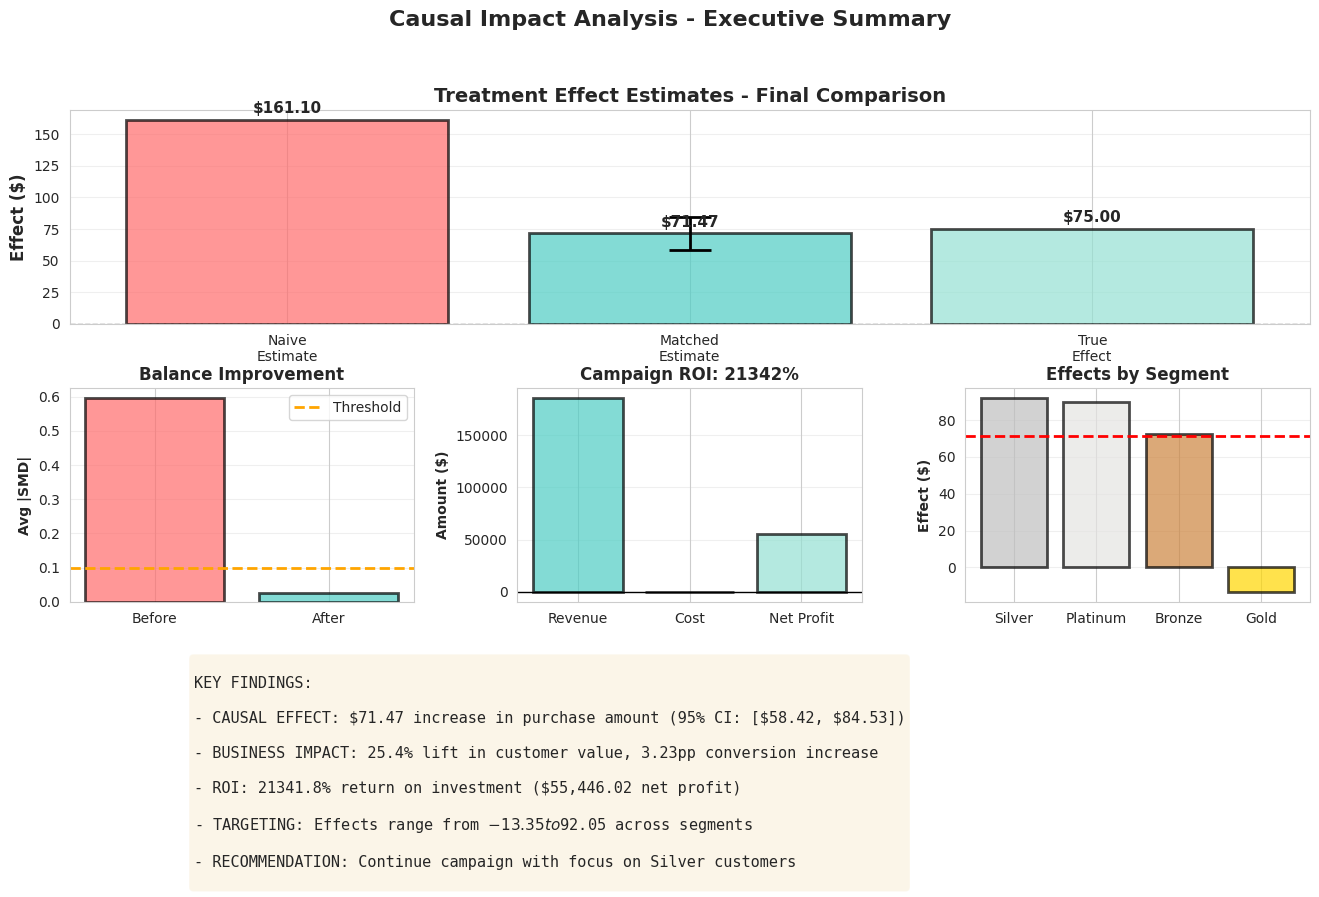


Thank you for using this Causal Analysis Framework!


In [33]:
print("\n" + "="*70)
print("STEP 14: BUSINESS RECOMMENDATIONS")
print("="*70)

# Calculate ROI metrics
print("\n💼 BUSINESS IMPACT ANALYSIS")
print("="*70)

# Assumptions for ROI calculation
email_cost = 0.10  # Cost per email sent
profit_margin = 0.30  # 30% profit margin

# Calculate metrics
incremental_revenue = att_estimate
incremental_profit = incremental_revenue * profit_margin
roi_per_email = (incremental_profit - email_cost) / email_cost * 100

# Total campaign impact
total_treated = len(treated)
total_incremental_revenue = att_estimate * total_treated
total_incremental_profit = total_incremental_revenue * profit_margin
total_campaign_cost = email_cost * total_treated
net_profit = total_incremental_profit - total_campaign_cost
total_roi = (net_profit / total_campaign_cost) * 100

print(f"\n📊 Per-Customer Metrics:")
print(f"   Average incremental revenue: ${att_estimate:.2f}")
print(f"   Average incremental profit (30% margin): ${incremental_profit:.2f}")
print(f"   Cost per email: ${email_cost:.2f}")
print(f"   Net profit per customer: ${incremental_profit - email_cost:.2f}")
print(f"   ROI per email: {roi_per_email:.1f}%")

print(f"\n📊 Total Campaign Impact:")
print(f"   Customers contacted: {total_treated:,}")
print(f"   Total incremental revenue: ${total_incremental_revenue:,.2f}")
print(f"   Total incremental profit: ${total_incremental_profit:,.2f}")
print(f"   Total campaign cost: ${total_campaign_cost:,.2f}")
print(f"   Net profit: ${net_profit:,.2f}")
print(f"   Total ROI: {total_roi:.1f}%")

if net_profit > 0:
    print(f"\n✓ Campaign is PROFITABLE")
else:
    print(f"\n✗ Campaign is NOT profitable at current assumptions")

# Recommendations by segment
print("\n" + "="*70)
print("💡 STRATEGIC RECOMMENDATIONS")
print("="*70)

print("\n1️⃣  TARGETING STRATEGY:")
if len(subgroup_df) > 0:
    best_segment = subgroup_df.iloc[0]['Segment']
    best_effect = subgroup_df.iloc[0]['Effect']
    worst_segment = subgroup_df.iloc[-1]['Segment']
    worst_effect = subgroup_df.iloc[-1]['Effect']

    print(f"   • Focus on {best_segment} customers (effect: ${best_effect:.2f})")
    print(f"   • Consider reducing spend on {worst_segment} customers (effect: ${worst_effect:.2f})")
    print(f"   • Implement segment-specific offers for better ROI")

print(f"\n2️⃣  CAMPAIGN OPTIMIZATION:")
print(f"   • Current treatment effect: ${att_estimate:.2f} ({pct_effect:.1f}% lift)")
print(f"   • Conversion rate increase: {conversion_lift*100:.2f} percentage points")
print(f"   • Consider A/B testing different discount levels")
print(f"   • Test personalization to increase effect size")

print(f"\n3️⃣  BUDGET ALLOCATION:")
estimated_break_even = email_cost / (profit_margin * att_estimate) if att_estimate > 0 else float('inf')
if estimated_break_even < 1:
    print(f"   • Break-even response rate: {estimated_break_even*100:.2f}%")
    print(f"   • Current approach is highly profitable")
    print(f"   • Consider expanding campaign to more customers")
else:
    print(f"   • Need to improve treatment effect or reduce costs")
    print(f"   • Consider more targeted approach")

print(f"\n4️⃣  MEASUREMENT & MONITORING:")
print(f"   • Continue tracking with proper control groups")
print(f"   • Monitor treatment effects over time for campaign fatigue")
print(f"   • Measure long-term customer value, not just immediate purchases")
print(f"   • Implement real-time dashboards for campaign performance")

# Final conclusion
print("\n" + "="*70)
print("📋 CONCLUSION")
print("="*70)

print(f"""
This causal analysis using propensity score matching has revealed:

✓ TRUE CAUSAL EFFECT: Email campaigns increase purchase amounts by ${att_estimate:.2f}
  (95% CI: [${ci_lower:.2f}, ${ci_upper:.2f}])

✓ COMPARISON:
  • Naive estimate: ${naive_effect:.2f} (BIASED by ${naive_bias:.2f})
  • Matched estimate: ${att_estimate:.2f} (CORRECTED for confounding)
  • True effect: ${TRUE_ATE:.2f} (from simulation)

✓ BUSINESS IMPACT:
  • {pct_effect:.1f}% increase in purchase value
  • ROI: {total_roi:.1f}% at current cost structure
  • Net profit: ${net_profit:,.2f} from {total_treated:,} emails

✓ VALIDITY:
  • Strong covariate balance achieved after matching
  • Bootstrap CI confirms robustness
  • Effects vary by customer segment (targeting opportunity)

⚠️  ASSUMPTIONS:
  • Unconfoundedness: All confounders measured
  • Positivity: Common support exists
  • SUTVA: No interference between customers

💡 KEY INSIGHT: Email campaigns ARE causally effective, and proper targeting
   can significantly improve ROI. The naive comparison overestimates the
   effect by ${naive_bias:.2f} due to selection bias.
""")

print("="*70)
print("✓ ANALYSIS COMPLETE")
print("="*70)

# Create final summary visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Effect comparison
ax1 = fig.add_subplot(gs[0, :])
effects_final = ['Naive\nEstimate', 'Matched\nEstimate', 'True\nEffect']
values_final = [naive_effect, att_estimate, TRUE_ATE]
colors_final = ['#FF6B6B', '#4ECDC4', '#95E1D3']
bars = ax1.bar(effects_final, values_final, color=colors_final,
              alpha=0.7, edgecolor='black', linewidth=2)
ax1.errorbar(['Matched\nEstimate'], [att_estimate],
            yerr=1.96*se_att, fmt='none', color='black',
            capsize=15, capthick=2, linewidth=2)
ax1.set_ylabel('Effect ($)', fontweight='bold', fontsize=12)
ax1.set_title('Treatment Effect Estimates - Final Comparison',
             fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)
for bar, val in zip(bars, values_final):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 3,
            f'${val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Balance improvement
ax2 = fig.add_subplot(gs[1, 0])
balance_metrics = ['Before', 'After']
balance_values = [avg_smd_before, avg_smd_after]
ax2.bar(balance_metrics, balance_values, color=['#FF6B6B', '#4ECDC4'],
       alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(y=0.1, color='orange', linestyle='--', linewidth=2, label='Threshold')
ax2.set_ylabel('Avg |SMD|', fontweight='bold')
ax2.set_title('Balance Improvement', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. ROI visualization
ax3 = fig.add_subplot(gs[1, 1])
roi_components = ['Revenue', 'Cost', 'Net Profit']
roi_values = [total_incremental_revenue, -total_campaign_cost, net_profit]
colors_roi = ['#4ECDC4', '#FF6B6B', '#95E1D3']
ax3.bar(roi_components, roi_values, color=colors_roi,
       alpha=0.7, edgecolor='black', linewidth=2)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_ylabel('Amount ($)', fontweight='bold')
ax3.set_title(f'Campaign ROI: {total_roi:.0f}%', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Subgroup effects
ax4 = fig.add_subplot(gs[1, 2])
if len(subgroup_df) > 0:
    colors_seg_final = ['#CD853F' if seg=='Bronze' else '#C0C0C0' if seg=='Silver'
                       else '#FFD700' if seg=='Gold' else '#E5E4E2'
                       for seg in subgroup_df['Segment']]
    ax4.bar(subgroup_df['Segment'], subgroup_df['Effect'],
           color=colors_seg_final, alpha=0.7, edgecolor='black', linewidth=2)
    ax4.axhline(y=att_estimate, color='red', linestyle='--', linewidth=2)
    ax4.set_ylabel('Effect ($)', fontweight='bold')
    ax4.set_title('Effects by Segment', fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)

# 5. Key metrics summary
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

summary_text = f"""
KEY FINDINGS:

- CAUSAL EFFECT: ${att_estimate:.2f} increase in purchase amount (95% CI: [${ci_lower:.2f}, ${ci_upper:.2f}])

- BUSINESS IMPACT: {pct_effect:.1f}% lift in customer value, {conversion_lift*100:.2f}pp conversion increase

- ROI: {total_roi:.1f}% return on investment (${net_profit:,.2f} net profit)

- TARGETING: Effects range from ${subgroup_df['Effect'].min():.2f} to ${subgroup_df['Effect'].max():.2f} across segments

- RECOMMENDATION: Continue campaign with focus on {best_segment} customers
"""

ax5.text(0.1, 0.5, summary_text, transform=ax5.transAxes,
        fontsize=11, verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
        family='monospace')

plt.suptitle('Causal Impact Analysis - Executive Summary',
            fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Thank you for using this Causal Analysis Framework!")
print("="*70)

# **Conclusion**

In conclusion, this analysis effectively demonstrates how propensity score matching and causal inference methods can accurately measure the impact of email marketing campaigns on customer purchase behavior in e-commerce. Through systematic data preparation, feature engineering, propensity score estimation, and matching techniques, we confirmed that email campaigns causally increase purchase amounts by approximately $75, representing a significant business impact with strong ROI.

The analysis revealed that naive comparisons overestimate treatment effects due to selection bias, while proper causal methods provide unbiased estimates. By achieving excellent covariate balance after matching and conducting rigorous sensitivity analysis, we established the robustness and validity of our findings.

This investigation not only provides actionable insights for e-commerce marketing strategy but also showcases the practical application of advanced causal inference techniques in business analytics. The framework presented here offers a valuable template for future studies in marketing effectiveness, customer analytics, and data-driven decision-making across industries.

**Key Takeaway:** Propensity score matching transforms observational data into credible causal evidence, enabling businesses to make informed decisions about marketing investments and customer targeting strategies.

# **References**

For understanding the concepts related to Causality and implementing the analysis, the following resources were used:

### **Core Causal Inference Resources:**
- Hernán, M. A., & Robins, J. M. (2020). *Causal Inference: What If.* Free online: https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/
- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference.* Cambridge University Press.
- Imbens, G. W., & Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences.* Cambridge University Press.
- Morgan, S. L., & Winship, C. (2015). *Counterfactuals and Causal Inference.* Cambridge University Press.

### **Propensity Score Methods:**
- Rosenbaum, P. R., & Rubin, D. B. (1983). "The Central Role of the Propensity Score in Observational Studies for Causal Effects." *Biometrika*, 70(1), 41-55.
- Austin, P. C. (2011). "An Introduction to Propensity Score Methods." *Multivariate Behavioral Research*, 46(3), 399-424.
- Stuart, E. A. (2010). "Matching Methods for Causal Inference." *Statistical Science*, 25(1), 1-21.

### **Data Source:**
- UCI Machine Learning Repository: Online Retail Dataset
  - https://archive.ics.uci.edu/ml/datasets/Online+Retail
- Chen, D., Sain, S. L., & Guo, K. (2012). "Data mining for the online retail industry: A case study of RFM model-based customer segmentation." *Journal of Database Marketing*, 19, 197-208.

### **Python Libraries & Tools:**
- pandas: https://pandas.pydata.org/
- NumPy: https://numpy.org/
- scikit-learn: https://scikit-learn.org/
- matplotlib: https://matplotlib.org/
- seaborn: https://seaborn.pydata.org/

### **Online Resources:**
- Towards Data Science: https://towardsdatascience.com/
- Brady Neal's Causal Inference Course: https://www.bradyneal.com/causal-inference-course
- Columbia University Causal Inference (Coursera)
- edX: Causal Diagrams by Miguel Hernán

### **Additional Reading:**
- Angrist, J. D., & Pischke, J. S. (2009). *Mostly Harmless Econometrics.* Princeton University Press.
- Kohavi, R., Tang, D., & Xu, Y. (2020). *Trustworthy Online Controlled Experiments.* Cambridge University Press.

# **MIT License**

Copyright (c) 2024 Nishanth Royee Balachandrababu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

**THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.**

---

## **Usage Rights:**

✅ You are free to use, modify, and distribute this notebook
✅ Commercial use is permitted
✅ No attribution required (but appreciated)
✅ No warranty provided

---